# Final Project Part A

In [1]:
# Install libraries
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from itertools import product
from IPython.display import display, HTML
from pandas_market_calendars import get_calendar 
import matplotlib.ticker as mtick # for the last few efficient frontier plots
import warnings
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
warnings.filterwarnings("ignore")

aspect_ratio = (12, 8)
annualization_factor=260

# 1

First let's define all the functions:

In [2]:
def read_price_data(filename,index_col=0, parse_dates=True):
    
    # Read the CSV file specifying that the first Date column is the index column 
    # Dates should be parsed as dateTimes    
    df = pd.read_csv(filename, index_col=index_col, parse_dates=parse_dates)
    
    # Print out the Dataframe’s info
    bold_text = '<strong>Dataframe info:</strong>'
    display(HTML(bold_text))
    print(df.info())
    
    # Check if any NULL values
    bold_text = '<strong>Null values check:</strong>'
    display(HTML(bold_text))
    print(df.isnull().sum())
    
    # Summary Statistics
    bold_text = '<strong>Summary Statistics:</strong>'
    display(HTML(bold_text))
    print(df.describe())
    
    # Display the Dataframe
    bold_text = '<strong>Display Dataframe:</strong>'
    display(HTML(bold_text))
    print(df)
    
    # Return the Dataframe
    return df

In [3]:
def plot_and_format_y_axis(data_frame, formatter = None, aspect_ratio = (12,8), title ='', ylabel = '', grid = True):
    
    ax = data_frame.plot(figsize=aspect_ratio, title=title, ylabel=ylabel, grid=grid)

    # Create a custom y-axis formatter
    if formatter != None:
        def currency_formatter(x, pos):
            if formatter == 'Dollar':
                return f"${x:,.2f}"  # Format as currency with 2 decimal places
            elif formatter == 'Percent':
                return f"{100*x:,.2f}%"  # Format as percentage with 2 decimal places

        yaxis_formatter = ticker.FuncFormatter(currency_formatter)
        ax.yaxis.set_major_formatter(yaxis_formatter)
    
    plt.show()

In [4]:
def print_pct_data(data_frame, format_spec = "{:.4%}", na_rep = "NaN", index_slice=None):
    
    # Create a copy of the input DataFrame
    formatted_df = data_frame.copy()

    if index_slice is not None:
        # Apply the formatting to the specified index_slice using applymap
        formatted_df.loc[index_slice] = formatted_df.loc[index_slice].applymap(lambda x: format_spec.format(x) if not pd.isna(x) else na_rep)
    
    else:
        formatted_df = data_frame.style.format(format_spec, na_rep = na_rep)

    return formatted_df

In [5]:
def insert_first_nan_row(returns_df):

    calendar_name = "XNYS"  # NYSE calendar
    start_date = pd.Timestamp(returns_df[0:1].index[0])
    num_weeks = 1  # 1 week before the start date

    # Get the specified calendar
    calendar = get_calendar(calendar_name)

    # Calculate the end date as 1 week before the start date
    end_date = start_date - pd.DateOffset(weeks=num_weeks)

    # Get the valid business days in the specified date range
    valid_business_days = calendar.valid_days(start_date=end_date, end_date=start_date)

    # Find the last but one date
    last_but_one_date = valid_business_days[-2]

    date_value = last_but_one_date.date()

    previous_bday_df = returns_df[0:1].copy()
    previous_bday_df.index = pd.DatetimeIndex([date_value])

    # Set the name of the index
    previous_bday_df.index.name = 'Date'

    # Replace all column values with NaN
    previous_bday_df[:] = np.nan

    # Concatenate the two DataFrames
    combined_df = pd.concat([previous_bday_df, returns_df])

    # Print the combined DataFrame
    return combined_df


In [6]:
def calcSummaryStatistics(returns_df, annualization_factor=260, print_screen=True, percent_format_string="{:.2%}"):
    
    # Check if the DataFrame has a first NaN row
    if not returns_df.iloc[0].isna().any():
        
        # Insert a first NaN row with a proper (t-1) business date
        returns_df = insert_first_nan_row(returns_df)
   
    if ( (returns_df.iloc[0].isna().any() and not returns_df.iloc[0].isna().all()) | (returns_df[1:].isna().any().any()) ):
        raise ValueError("DataFrame contains a first NaN row, but not all columns are NaN, OR it has a NaN row that is not the first row.")
        

    # Cumulate the log returns, replacing NaN with zeros
    cumReturns = returns_df.cumsum().fillna(0)
    underWaterCurve = cumReturns.fillna(0) - np.maximum.accumulate(cumReturns.fillna(0))


    # Calculate the Summary statistics
    summary_stats = pd.DataFrame([annualization_factor*returns_df.mean(), 
                                  np.sqrt(annualization_factor)*returns_df.std(),
                                  underWaterCurve.min(axis=0),
                                  (returns_df >= 0).sum() / (returns_df.dropna().shape[0]),
                                  returns_df.mean() / returns_df.std() * np.sqrt(annualization_factor)],
                                 index=['Average Annual Return', 'Annual Risk', 'maxDD', 'Success Ratio', 'Sharpe Ratio'])

    performance_statistics = print_pct_data(summary_stats, format_spec = percent_format_string, index_slice=pd.IndexSlice['Average Annual Return':'Success Ratio'])
        
    # Pretty print summary statistics
    if print_screen:
        print(performance_statistics)
    
    return performance_statistics

In [7]:
# Write function to implement moving average crossover strategy
# Input: Call this function with a dataframe having only one column representing prices of an instrument
# Output: Return a dataframe having three columns (original, go-flat, and go-short) of daily returns

def movingAverageCrossover(dataFrame, fastWindow, slowWindow):
   
    # Check to make sure the dataFrame has only 1 column 
    if len(dataFrame.columns) != 1:
        raise ValueError('The dataframe must only have 1 column.')
        
    # Name of the security
    security_name = dataFrame.columns[0]
    
    # Make a copy of the original dataframe
    df = dataFrame.copy()
    
    # Calculate fast and slow moving averages 
    df.loc[:,'FastSMA'] = df[security_name].rolling(window=fastWindow).mean()
    df.loc[:,'SlowSMA'] = df[security_name].rolling(window=slowWindow).mean()
    
    # Drop NaN values 
    df.dropna(inplace=True)
    
    
    ## Go flat strategy
    # SMA strategy: if rising trend, stay long, otherwise go flat
    df.loc[:,'Position_goflat'] = np.where(df['FastSMA'] > df['SlowSMA'], 1, 0)

    # Calculate daily returns 
    df.loc[:,'BMKReturns'] = np.log(df[security_name] / df[security_name].shift(1))
    
    # Then calculate the strategy returns, taking care to push down the Position column
    df.loc[:,'SMAReturns_goflat'] = df['Position_goflat'].shift(1) * df['BMKReturns']
    
    # Uncomment below to plot
    #ax = df[['BMKReturns', 'SMAReturns_goflat']].cumsum().plot(figsize=aspect_ratio, ylabel='NAV', title='Original and SMA Strategy Cumulative NAVs', grid=True)

    
    ## Go short strategy
    # SMA strategy: if rising trend, stay long, otherwise go short
    df.loc[:,'Position_goshort'] = np.where(df['FastSMA'] > df['SlowSMA'], 1, -1)

    # Then calculate the strategy returns, taking care to push down the Position column
    df.loc[:,'SMAReturns_goshort'] = df['Position_goshort'].shift(1) * df['BMKReturns']

    # Uncomment below to plot
    #ax = df[['BMKReturns', 'SMAReturns_goshort']].cumsum().plot(figsize=aspect_ratio, ylabel='NAV', title='Original and SMA Strategy Cumulative NAVs', grid=True)

    df = df[['BMKReturns', 'SMAReturns_goflat', 'SMAReturns_goshort']]

    # Rename the columns
    df.rename(columns={'BMKReturns': f"{security_name}-BMK",'SMAReturns_goflat': f"{security_name}-MAFlat",
       'SMAReturns_goshort': f"{security_name}-MAShort"}, inplace=True)

    return df


In [8]:
def bollingerBands(dataFrame, lookbackWindow, stdevBand):
    
    # Check to make sure the dataFrame has only 1 column 
    if len(dataFrame.columns) != 1:
        raise ValueError('The dataframe must only have 1 column.')
        
    # Name of the security
    security_name = dataFrame.columns[0]
    
    # Make a copy of the original dataframe
    df = dataFrame.copy()
    
    # Calculate the rolling mean and the rolling risk
    df.loc[:,'Mean'] = df[security_name].rolling(lookbackWindow).mean()
    df.loc[:,'Stdev'] = df[security_name].rolling(lookbackWindow).std()

    # Drop NaN values 
    df.dropna(inplace=True)
    
    # Next we create the Upper and Lower bands
    df.loc[:,'Upper'] = df['Mean'] + stdevBand * df['Stdev']
    df.loc[:,'Lower'] = df['Mean'] - stdevBand * df['Stdev']  

    # Now we implement the Bollinger band based strategy
    
    date0 = df.index[0]
    if df.loc[date0,security_name] >= df.loc[date0, 'Upper']:
        df.loc[date0, 'Position'] = -1
    elif df.loc[date0,security_name] <= df.loc[date0,'Lower']:
        df.loc[date0, 'Position'] = 1
    else:
        df.loc[date0, 'Position'] = 0

    # Then loop over the entire data set
    for i in range(1, df.shape[0]):
        today=df.index[i]
        yesterday=df.index[i-1]
        if df.loc[today,security_name] >= df.loc[today,'Upper']: # if close is above upper
            df.loc[today,'Position'] = -1 # then go short
        elif df.loc[today,security_name] <= df.loc[today,'Lower']: # if close is below lower
            df.loc[today,'Position'] = 1 # then go long
        elif df.loc[yesterday,'Position'] == -1 and df.loc[today,security_name] <= df.loc[today,'Mean']: # if prev day is short and we're now below the mean
            df.loc[today,'Position']=0 # then flatten
        elif df.loc[yesterday,'Position'] == 1 and df.loc[today, security_name] >= df.loc[today, 'Mean']: # conversely...
            df.loc[today,'Position']=0 # then also flatten
        else: # otherwise just hold yesterday's position
            df.loc[today,'Position']=df.loc[yesterday,'Position']
    
    
    # Now we calculate returns. First, the "benchmark" (or original) returns, the stock itself
    # first, calculate stock price log returns
    df.loc[:,'BMKReturns'] = np.log(df[security_name] / df[security_name].shift(1))
    
    # Then we calculate our strategy returns, taking care to multiply last night's position by today's benchmark return
    df.loc[:,'BBReturns'] = df['Position'].shift(1) * df['BMKReturns']
    
    df = df[['BMKReturns', 'BBReturns']]

    # Rename the columns
    df.rename(columns={'BMKReturns': f"{security_name}-BMK",'BBReturns': f"{security_name}-BB"}, inplace=True)

                       
    return df

Read in data from the file "Prices.csv":

In [9]:
prices_df = read_price_data('Prices.csv')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4780 entries, 1999-12-31 to 2018-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    4780 non-null   float64
 1   CAD     4780 non-null   float64
 2   EXC     4780 non-null   float64
 3   FBNDX   4780 non-null   float64
 4   GBP     4780 non-null   float64
 5   GE      4780 non-null   float64
 6   INTC    4780 non-null   float64
 7   PFE     4780 non-null   float64
 8   SPGSCI  4780 non-null   float64
 9   SPY     4780 non-null   float64
 10  VBTIX   4780 non-null   float64
 11  XPT     4780 non-null   float64
dtypes: float64(12)
memory usage: 485.5 KB
None


AAPL      0
CAD       0
EXC       0
FBNDX     0
GBP       0
GE        0
INTC      0
PFE       0
SPGSCI    0
SPY       0
VBTIX     0
XPT       0
dtype: int64


              AAPL          CAD          EXC        FBNDX          GBP  \
count  4780.000000  4780.000000  4780.000000  4780.000000  4780.000000   
mean     12.912473     0.834533    29.142045     7.477059     1.603932   
std      13.984758     0.122196    10.492082     0.378748     0.199244   
min       0.234286     0.619771    11.991797     6.170000     1.212300   
25%       1.089286     0.749288    22.324359     7.260000     1.462875   
50%       6.524464     0.818465    26.401570     7.520000     1.580300   
75%      22.634555     0.951928    32.767475     7.770000     1.735400   
max      58.017502     1.086484    65.363770     8.060000     2.107500   

                GE         INTC          PFE       SPGSCI          SPY  \
count  4780.000000  4780.000000  4780.000000  4780.000000  4780.000000   
mean    169.689010    28.209522    27.602742   435.612420   150.584286   
std      61.018497    10.651262     7.617317   161.215919    50.909008   
min      39.992794    12.080000    11

                 AAPL       CAD        EXC  FBNDX     GBP          GE  \
Date                                                                    
1999-12-31   0.917969  0.691515  12.393010   6.89  1.6182  309.753998   
2000-01-03   0.999442  0.691181  12.080956   6.85  1.6362  300.246216   
2000-01-04   0.915179  0.688326  11.991797   6.87  1.6360  288.236359   
2000-01-05   0.928571  0.689655  12.571327   6.84  1.6426  287.735931   
2000-01-06   0.848214  0.684978  12.593616   6.86  1.6474  291.582855   
...               ...       ...        ...    ...     ...         ...   
2018-12-24  36.707500  0.735456  31.262482   7.68  1.2706   41.554073   
2018-12-26  39.292500  0.736703  31.726107   7.65  1.2633   44.376389   
2018-12-27  39.037498  0.734268  31.940086   7.63  1.2644   43.655800   
2018-12-28  39.057499  0.733245  31.911554   7.66  1.2699   45.096981   
2018-12-31  39.435001  0.733299  32.168331   7.67  1.2754   45.457275   

                 INTC        PFE    SPGSCI        

# 2.

### Analysis for selecting instruments from the given dataset:

To have an idea on initial Sharpe values, display performance statistics:

In [10]:
# Compute log returns
logReturns = np.log(prices_df / prices_df.shift(1))
prices_stats = calcSummaryStatistics(logReturns, print_screen=True)

                           AAPL       CAD       EXC     FBNDX       GBP  \
Average Annual Return    20.46%     0.32%     5.19%     0.58%    -1.30%   
Annual Risk              43.31%     9.22%    26.12%     3.80%     9.51%   
maxDD                  -170.38%   -45.99%  -128.08%   -23.70%   -55.30%   
Success Ratio            52.25%    50.55%    52.37%    64.72%    50.70%   
Sharpe Ratio           0.472338  0.034611  0.198705  0.153742 -0.136238   

                             GE      INTC       PFE    SPGSCI       SPY  \
Average Annual Return   -10.44%     0.71%     1.62%     3.56%     2.89%   
Annual Risk              31.36%    37.96%    25.34%    23.53%    19.57%   
maxDD                  -219.82%  -182.43%  -143.57%  -118.65%   -83.18%   
Success Ratio            49.99%    51.73%    50.47%    52.02%    53.90%   
Sharpe Ratio          -0.332952  0.018816   0.06373  0.151303  0.147747   

                          VBTIX       XPT  
Average Annual Return     0.48%     3.19%  
Annual Ris

Plotting the NAV lines would help us to understand the trend over the entire period:

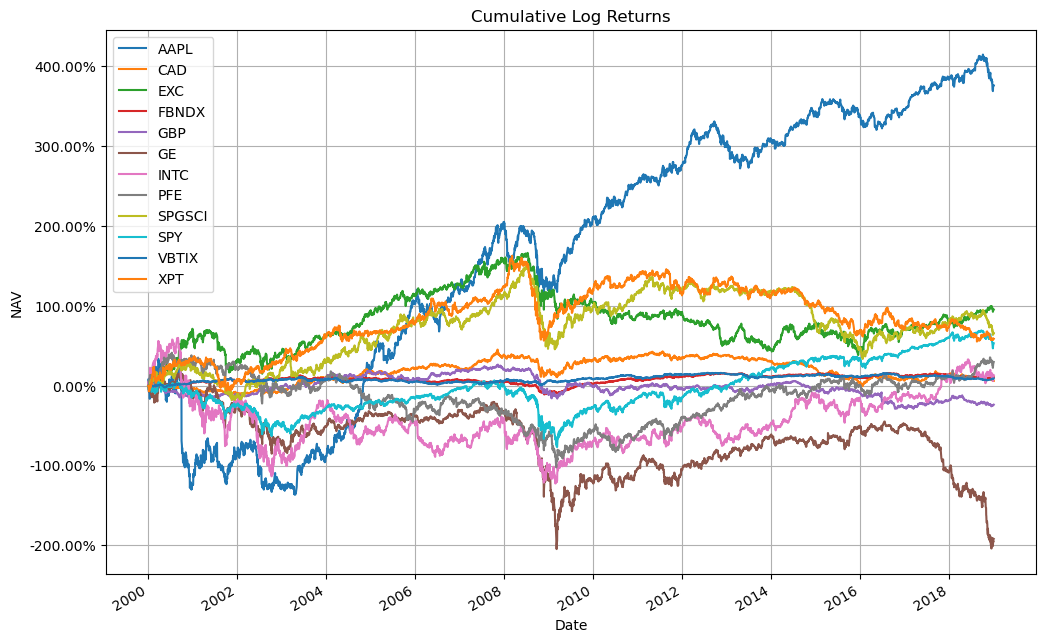

In [11]:
# Cumulate the log returns, replacing NaN with zeros
cumReturns = logReturns.cumsum().fillna(0)

# Plot the cum returns
plot_and_format_y_axis(cumReturns ,formatter= 'Percent', title='Cumulative Log Returns', ylabel='NAV')

Look at the correlation matrix of these returns:

In [12]:
# Calculate the correlation matrix
correlation_matrix = logReturns.corr()
bold_text = '<strong>Correlation Matrix:</strong>'
display(HTML(bold_text))

print_pct_data(correlation_matrix)

Now we can run the MA crossover strategy for all instruments and then do parameter study looking at the “blue regions”:

Instrument Name: AAPL
Optimal 'go flat' strategy: Fast Window = 11, Slow Window = 220, Max Sharpe = 1.0125145882146425
Optimal 'go short' strategy: Fast Window = 53, Slow Window = 55, Max Sharpe = 0.8220107196692458


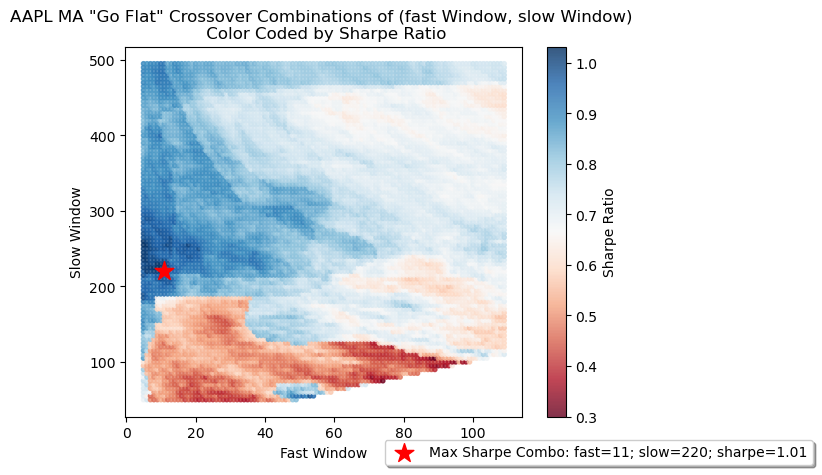

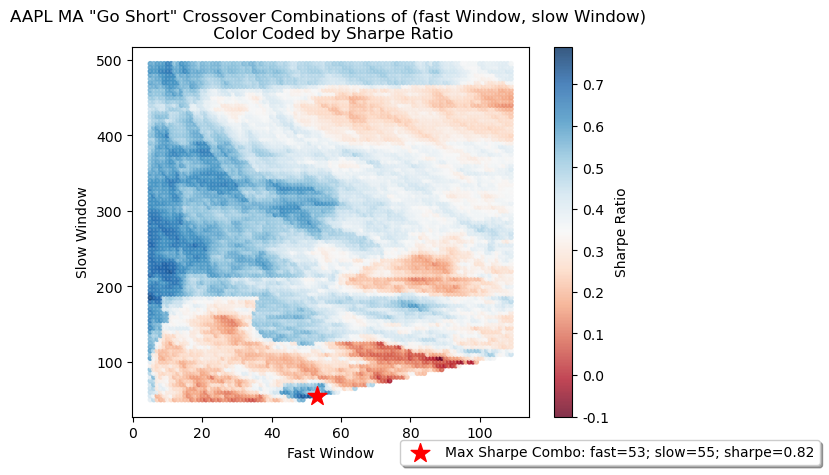

Instrument Name: CAD
Optimal 'go flat' strategy: Fast Window = 33, Slow Window = 135, Max Sharpe = 0.40829671722512484
Optimal 'go short' strategy: Fast Window = 33, Slow Window = 135, Max Sharpe = 0.507899070159781


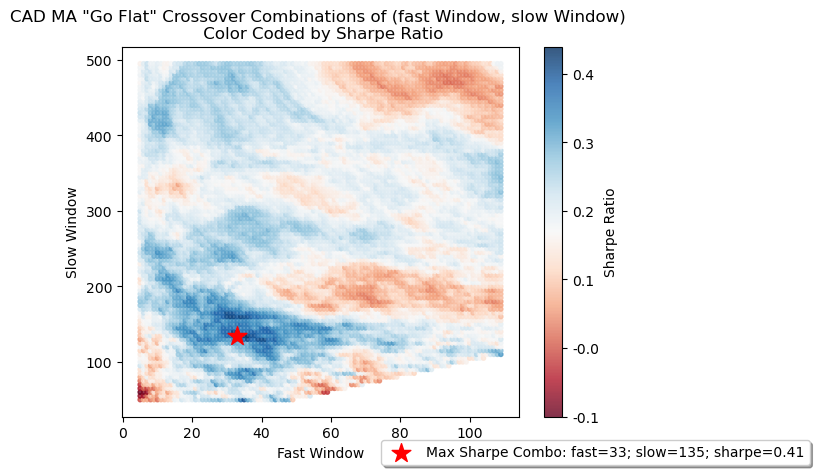

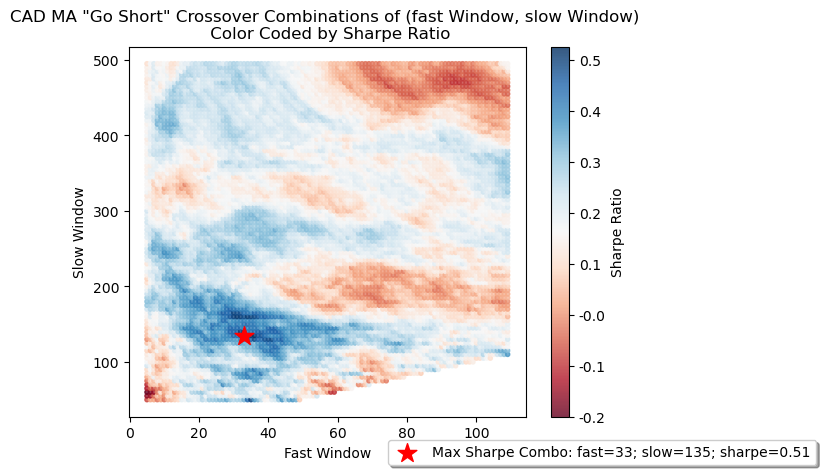

Instrument Name: EXC
Optimal 'go flat' strategy: Fast Window = 23, Slow Window = 50, Max Sharpe = 0.4117807228079647
Optimal 'go short' strategy: Fast Window = 34, Slow Window = 365, Max Sharpe = 0.41841996288691075


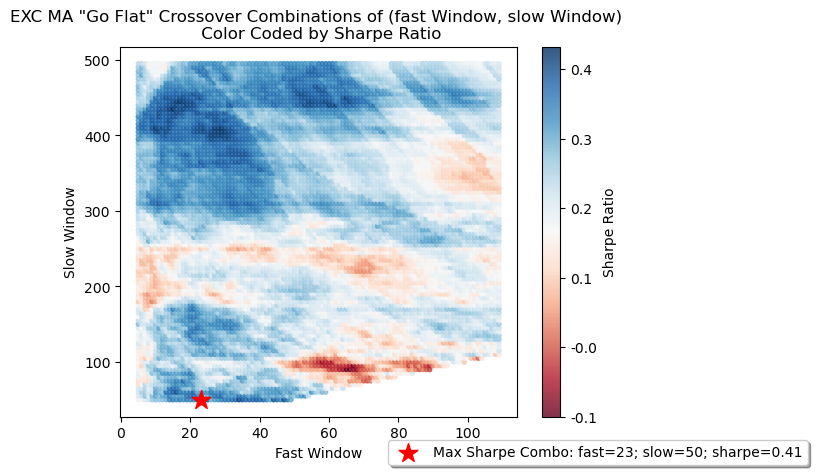

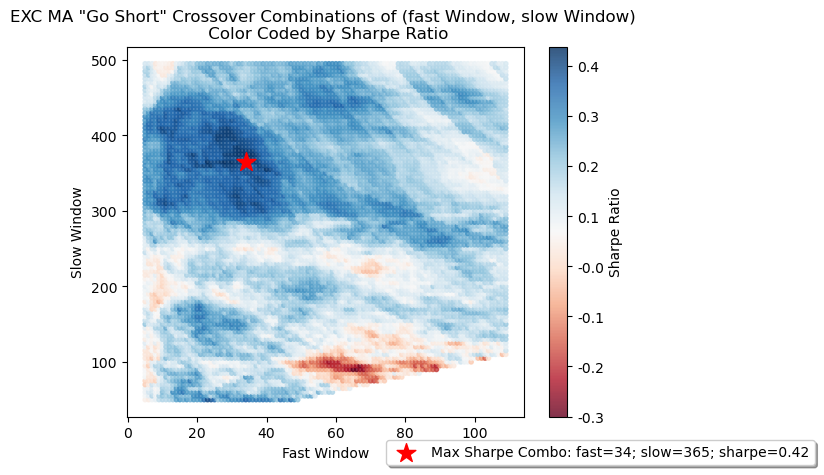

Instrument Name: FBNDX
Optimal 'go flat' strategy: Fast Window = 73, Slow Window = 80, Max Sharpe = 0.5942553398824925
Optimal 'go short' strategy: Fast Window = 73, Slow Window = 80, Max Sharpe = 0.6945634126094484


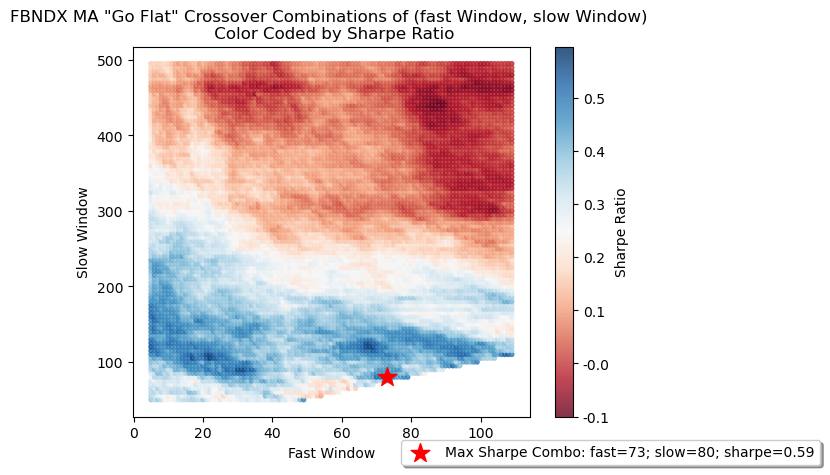

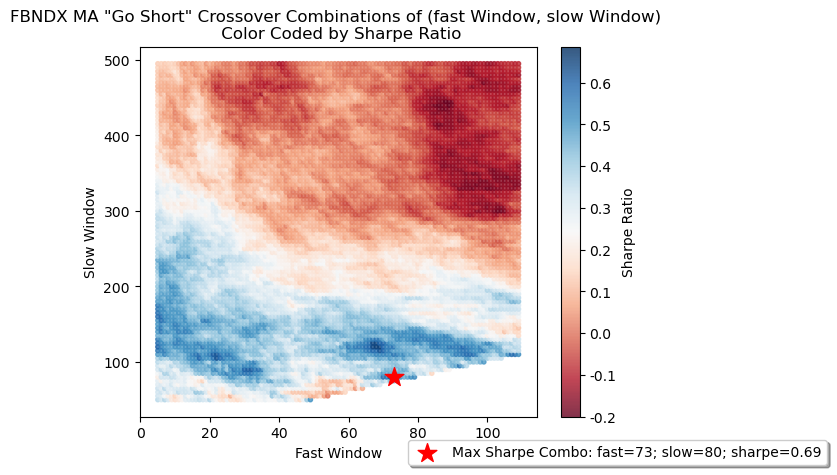

Instrument Name: GBP
Optimal 'go flat' strategy: Fast Window = 85, Slow Window = 100, Max Sharpe = 0.3785842358009619
Optimal 'go short' strategy: Fast Window = 87, Slow Window = 130, Max Sharpe = 0.5571258326195784


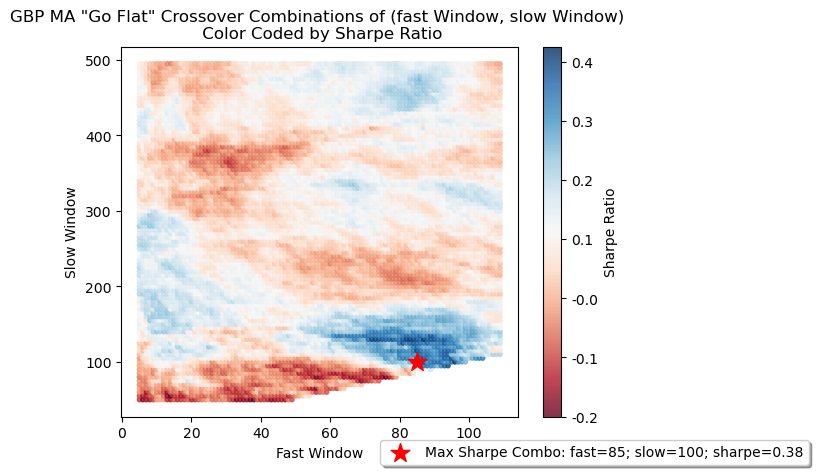

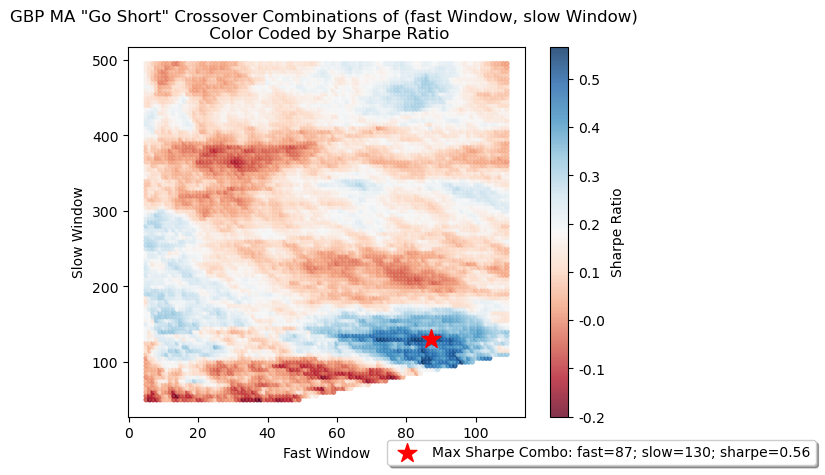

Instrument Name: GE
Optimal 'go flat' strategy: Fast Window = 96, Slow Window = 100, Max Sharpe = 0.24755182316017493
Optimal 'go short' strategy: Fast Window = 96, Slow Window = 100, Max Sharpe = 0.5894201859949351


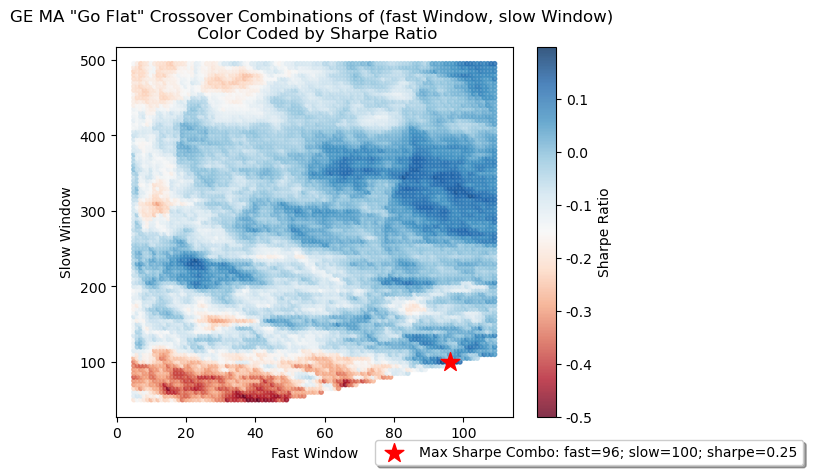

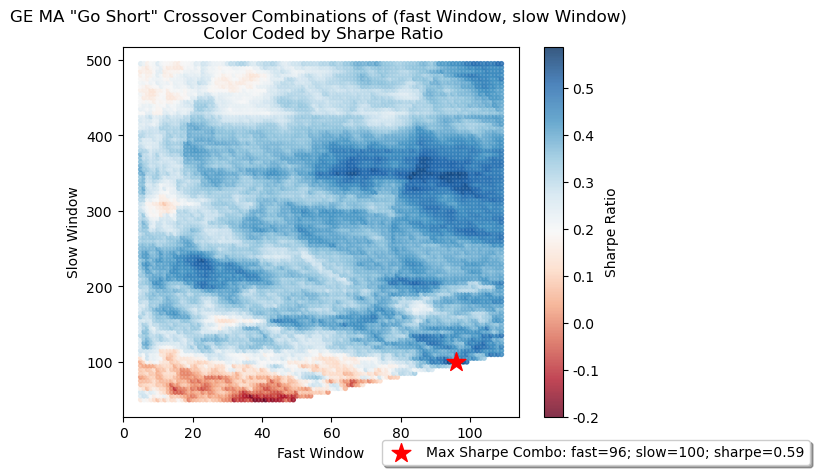

Instrument Name: INTC
Optimal 'go flat' strategy: Fast Window = 63, Slow Window = 215, Max Sharpe = 0.2052169871937377
Optimal 'go short' strategy: Fast Window = 68, Slow Window = 75, Max Sharpe = 0.26444251195783436


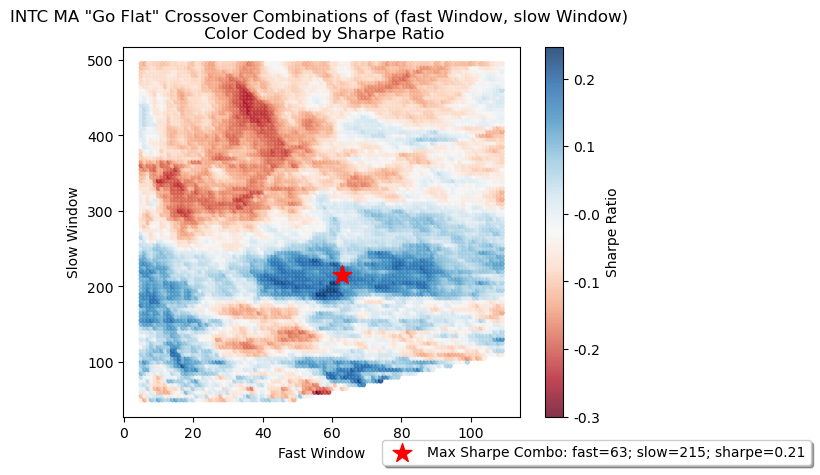

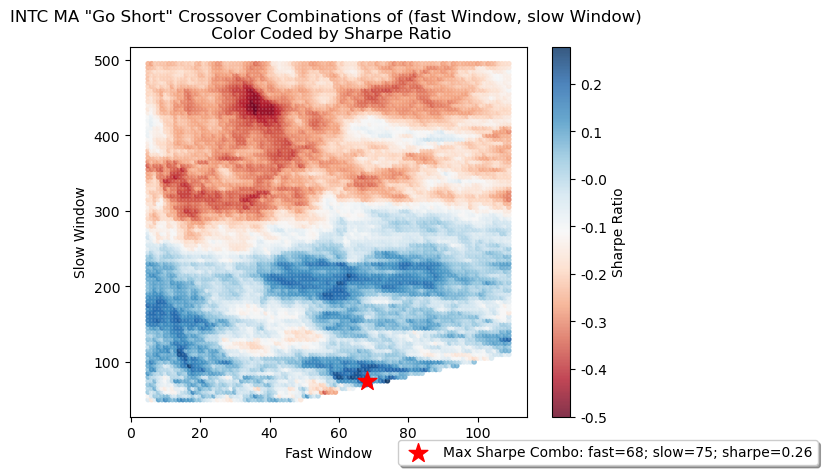

Instrument Name: PFE
Optimal 'go flat' strategy: Fast Window = 91, Slow Window = 225, Max Sharpe = 0.21019163660030124
Optimal 'go short' strategy: Fast Window = 46, Slow Window = 85, Max Sharpe = 0.2585250518229192


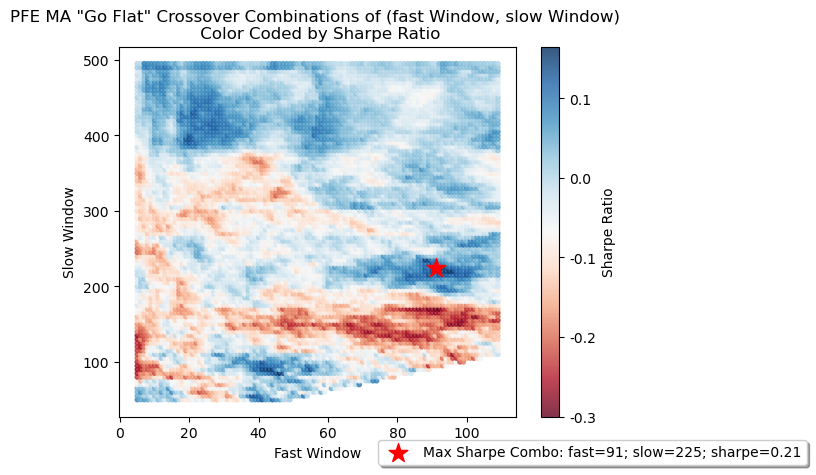

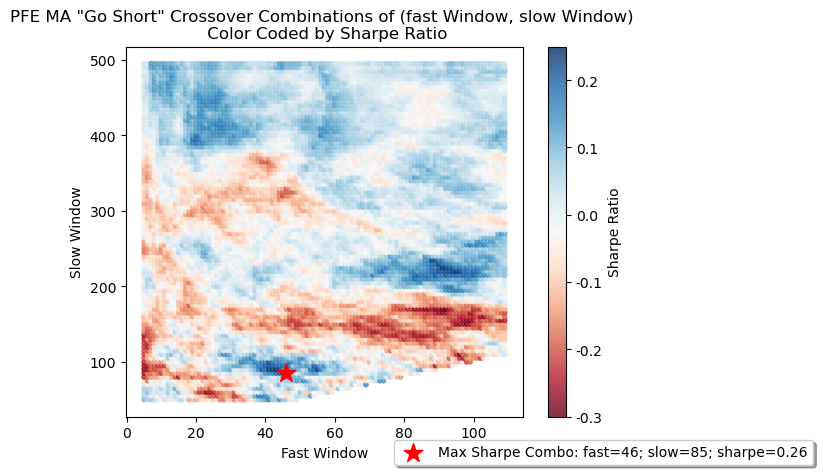

Instrument Name: SPGSCI
Optimal 'go flat' strategy: Fast Window = 37, Slow Window = 110, Max Sharpe = 0.5061390112717531
Optimal 'go short' strategy: Fast Window = 37, Slow Window = 110, Max Sharpe = 0.612786635109216


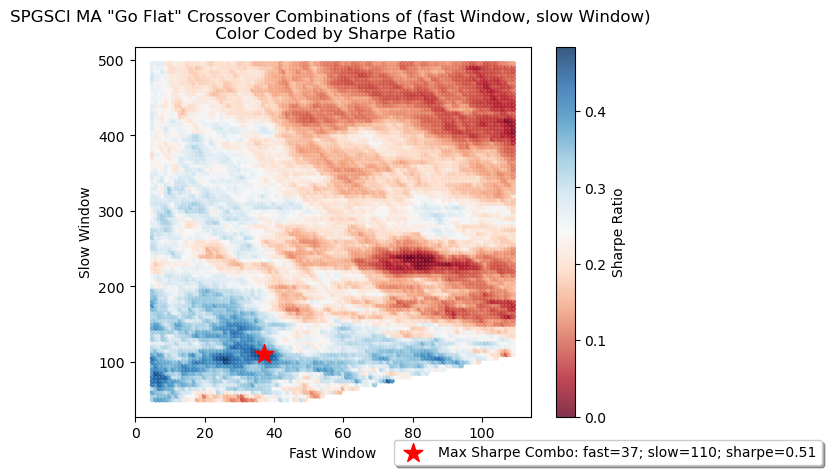

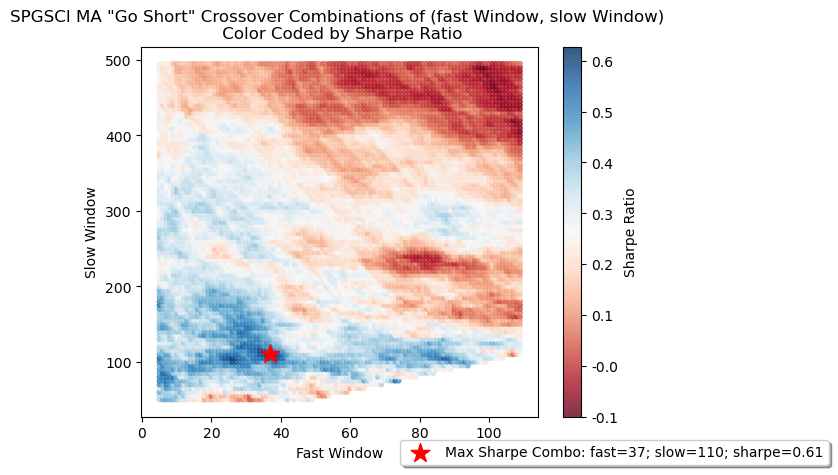

Instrument Name: SPY
Optimal 'go flat' strategy: Fast Window = 25, Slow Window = 235, Max Sharpe = 0.6549145046809602
Optimal 'go short' strategy: Fast Window = 33, Slow Window = 220, Max Sharpe = 0.5688775242523727


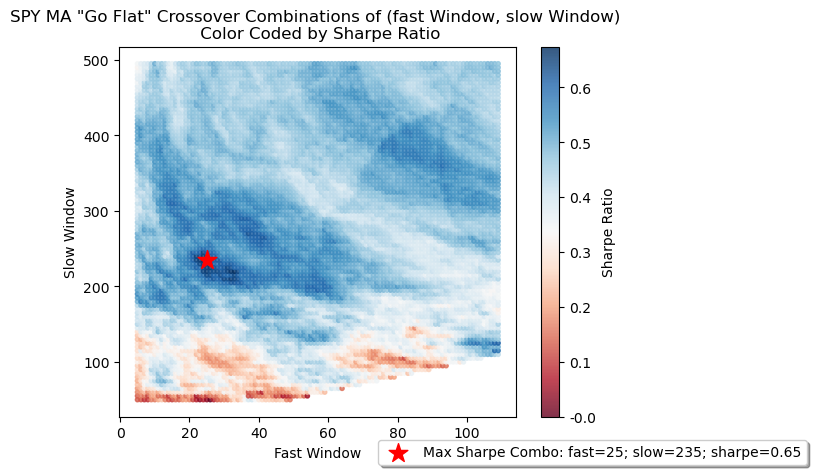

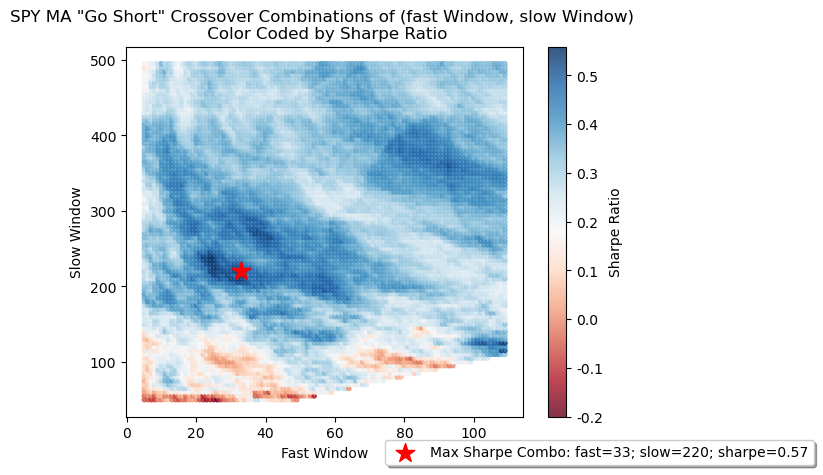

Instrument Name: VBTIX
Optimal 'go flat' strategy: Fast Window = 70, Slow Window = 90, Max Sharpe = 0.30374049270271836
Optimal 'go short' strategy: Fast Window = 74, Slow Window = 75, Max Sharpe = 0.31027923686269826


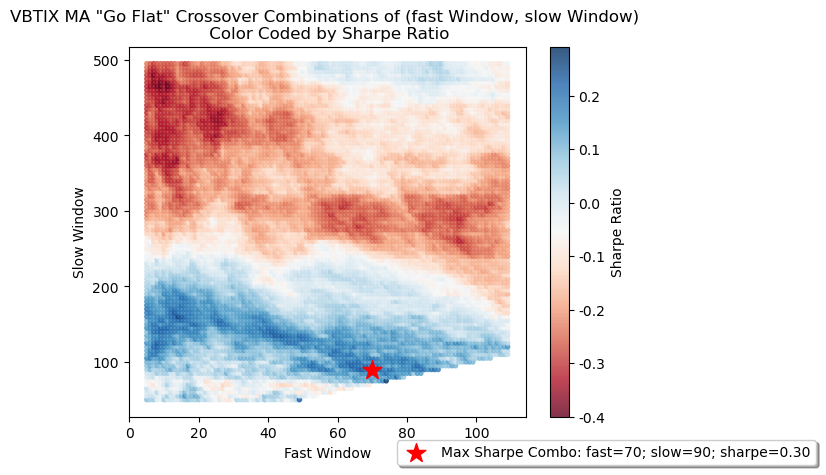

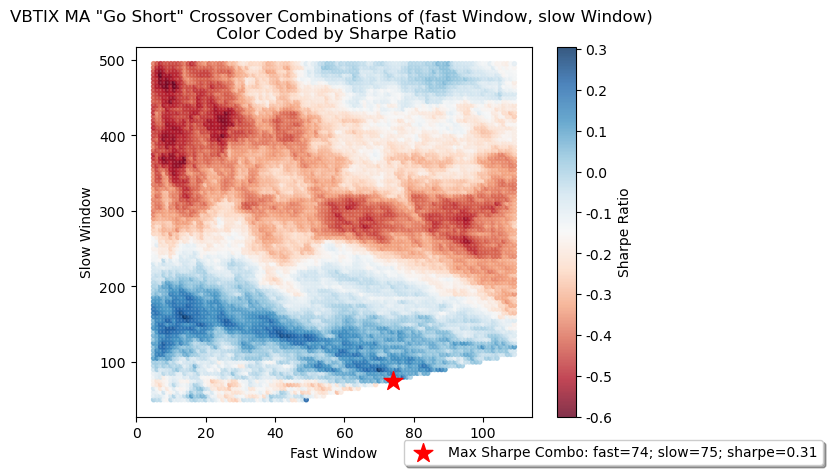

Instrument Name: XPT
Optimal 'go flat' strategy: Fast Window = 87, Slow Window = 105, Max Sharpe = 0.5194367570673353
Optimal 'go short' strategy: Fast Window = 87, Slow Window = 105, Max Sharpe = 0.6356771691969941


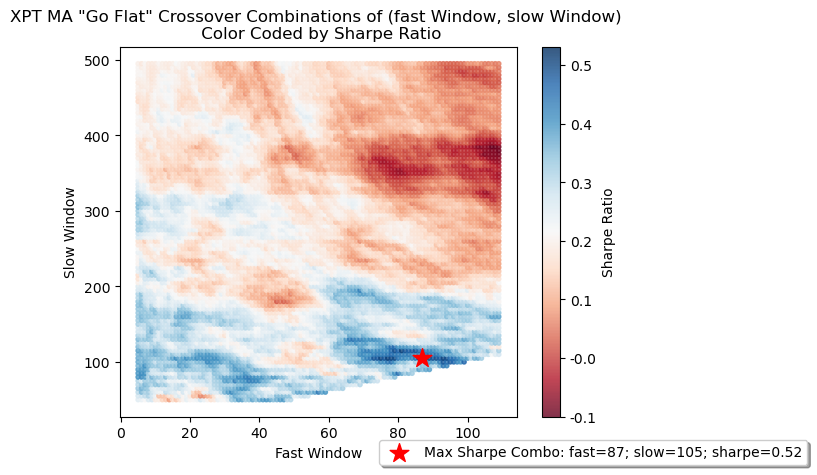

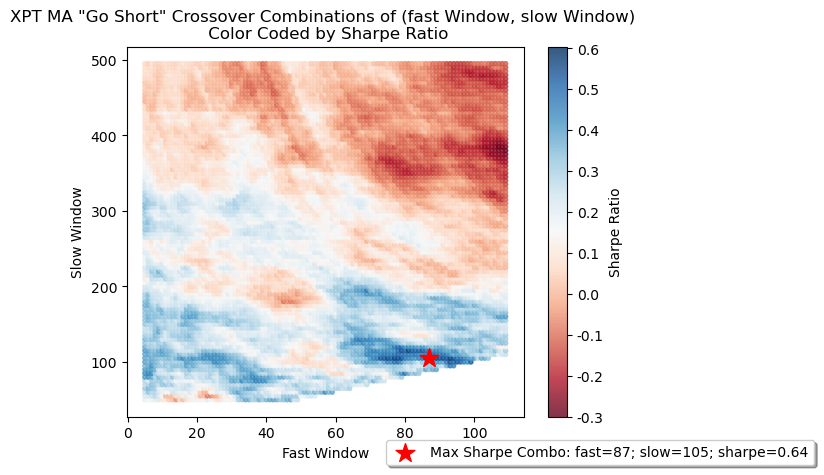

In [13]:
for column in prices_df.columns:   
    print(f'Instrument Name: {column}')
    dataframe = pd.DataFrame(prices_df[column])

    # Define the range of parameters
    fastWindow = range(5, 110)
    slowWindow = range(50, 500, 5)

    # Initialize arrays to collect Sharpes
    flat_sharpes = np.zeros((len(fastWindow), len(slowWindow)))
    short_sharpes = np.zeros((len(fastWindow), len(slowWindow)))

    # Iterate through combinations
    for i, fast_window in enumerate(fastWindow):
        for j, slow_window in enumerate(slowWindow):
            #print(i,j)
            # Ensure fastWindow < slowWindow
            if fast_window < slow_window:
                #print(fast_window,slow_window)

                # Run the movingAverageCrossover function
                result_df = movingAverageCrossover(dataframe, fast_window, slow_window)
                #print(result_df)

                # Calculate Sharpe ratios
                flat_sharpe = result_df.iloc[:, 1].mean() / result_df.iloc[:, 1].std() * np.sqrt(annualization_factor)
                short_sharpe = result_df.iloc[:, 2].mean() / result_df.iloc[:, 2].std() * np.sqrt(annualization_factor)

                # Collect Sharpes in arrays
                flat_sharpes[i, j] = flat_sharpe
                short_sharpes[i, j] = short_sharpe

    # Find the indices of the maximum Sharpe ratios for each strategy
    optimal_flat_index = np.unravel_index(np.argmax(flat_sharpes), flat_sharpes.shape)
    optimal_short_index = np.unravel_index(np.argmax(short_sharpes), short_sharpes.shape)

    # Get the optimal window parameters
    optimal_flat_window = fastWindow[optimal_flat_index[0]]
    optimal_slow_window_flat = slowWindow[optimal_flat_index[1]]

    optimal_short_window = fastWindow[optimal_short_index[0]]
    optimal_slow_window_short = slowWindow[optimal_short_index[1]]

    # Get the corresponding maximum Sharpe values
    max_sharpe_flat = flat_sharpes[optimal_flat_index]
    max_sharpe_short = short_sharpes[optimal_short_index]

    # Print the results
    print(f"Optimal 'go flat' strategy: Fast Window = {optimal_flat_window}, Slow Window = {optimal_slow_window_flat}, Max Sharpe = {max_sharpe_flat}")
    print(f"Optimal 'go short' strategy: Fast Window = {optimal_short_window}, Slow Window = {optimal_slow_window_short}, Max Sharpe = {max_sharpe_short}")

    # Used Chatgpt for scatter plot code below. There was no code in the lecture notebook for this. 
    # And then made changes accordingly to make it look similar to that shown in the class.

    # Generate all combinations of fastWindow and slowWindow
    all_combos = list(product(fastWindow, slowWindow))

    # Create the scatter plot with Sharpe ratios as the color
    scatter = plt.scatter(*zip(*all_combos), c=flat_sharpes.flatten(), cmap='RdBu', marker='.', alpha=0.8)

    # Replace 0 values with white in the color array
    flat_sharpes_no_zero = np.copy(flat_sharpes)
    flat_sharpes_no_zero[flat_sharpes_no_zero == 0] = np.nan

    # Set white color explicitly for points with Sharpe ratio equal to 0
    scatter.set_array(flat_sharpes_no_zero.flatten())
    scatter.set_cmap('RdBu')
    scatter.set_clim(vmin=np.nanmin(flat_sharpes_no_zero), vmax=np.nanmax(flat_sharpes_no_zero))

    # Highlight the point with the maximum Sharpe ratio in red
    plt.scatter(optimal_flat_window, optimal_slow_window_flat, c='red', marker='*', s=200, label=f'Max Sharpe Combo: fast={optimal_flat_window}; slow={optimal_slow_window_flat}; sharpe={max_sharpe_flat:.2f}')

    # Determine the range for colorbar ticks
    min_tick = np.nanmin(flat_sharpes_no_zero)
    max_tick = np.nanmax(flat_sharpes_no_zero)

    # Set colorbar ticks with equal spacing of 0.1
    ticks = np.arange(min_tick, max_tick, 0.1)

    # Add colorbar with red-to-blue colormap and white at 0
    cbar = plt.colorbar(scatter, label='Sharpe Ratio', ticks=ticks)
    cbar.set_ticklabels([f'{tick:.1f}' for tick in ticks])

    # Add legend at the bottom
    plt.legend(loc='lower right', bbox_to_anchor=(1.75, -0.15), fancybox=True, shadow=True, ncol=1)

    plt.xlabel("Fast Window")
    plt.ylabel("Slow Window")
    plt.title(f'{column} MA "Go Flat" Crossover Combinations of (fast Window, slow Window) \n Color Coded by Sharpe Ratio')

    # Show the plot
    plt.show()

    # Generate all combinations of fastWindow and slowWindow
    all_combos = list(product(fastWindow, slowWindow))

    # Create the scatter plot with Sharpe ratios as the color
    scatter = plt.scatter(*zip(*all_combos), c=short_sharpes.flatten(), cmap='RdBu', marker='.', alpha=0.8)

    # Replace 0 values with white in the color array
    short_sharpes_no_zero = np.copy(short_sharpes)
    short_sharpes_no_zero[short_sharpes_no_zero == 0] = np.nan

    # Set white color explicitly for points with Sharpe ratio equal to 0
    scatter.set_array(short_sharpes_no_zero.flatten())
    scatter.set_cmap('RdBu')
    scatter.set_clim(vmin=np.nanmin(short_sharpes_no_zero), vmax=np.nanmax(short_sharpes_no_zero))

    # Highlight the point with the maximum Sharpe ratio in red
    plt.scatter(optimal_short_window, optimal_slow_window_short, c='red', marker='*', s=200, label=f'Max Sharpe Combo: fast={optimal_short_window}; slow={optimal_slow_window_short}; sharpe={max_sharpe_short:.2f}')

    # Determine the range for colorbar ticks
    min_tick = np.nanmin(short_sharpes_no_zero)
    max_tick = np.nanmax(short_sharpes_no_zero)

    # Set colorbar ticks with equal spacing of 0.1
    ticks = np.arange(min_tick, max_tick, 0.1)

    # Add colorbar with red-to-blue colormap and white at 0
    cbar = plt.colorbar(scatter, label='Sharpe Ratio', ticks=ticks)
    cbar.set_ticklabels([f'{tick:.1f}' for tick in ticks])

    # Add legend at the bottom
    plt.legend(loc='lower right', bbox_to_anchor=(1.75, -0.15), fancybox=True, shadow=True, ncol=1)

    plt.xlabel("Fast Window")
    plt.ylabel("Slow Window")
    plt.title(f'{column} MA "Go Short" Crossover Combinations of (fast Window, slow Window) \n Color Coded by Sharpe Ratio')

    # Show the plot
    plt.show()


Similarly, run the Bollinger Band strategy for all instruments and then do parameter study looking at the “blue regions”:

Instrument Name: AAPL


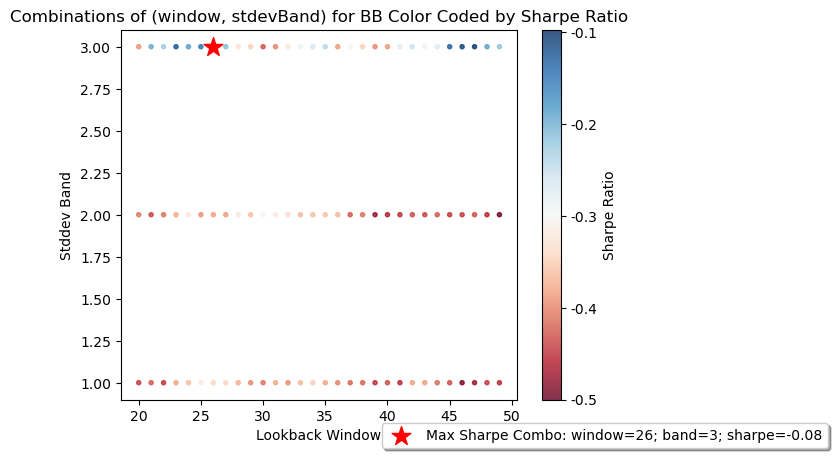

Instrument Name: CAD


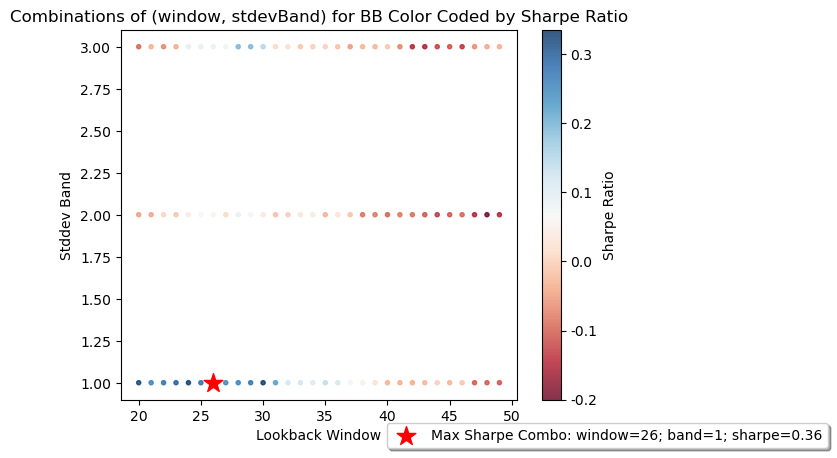

Instrument Name: EXC


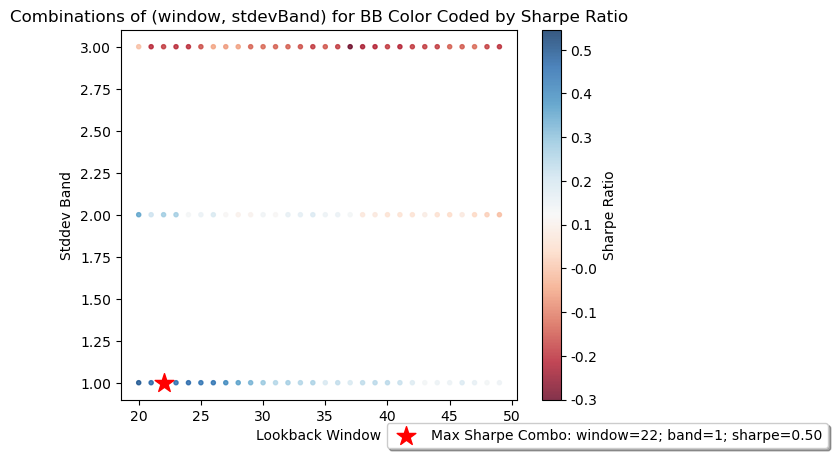

Instrument Name: FBNDX


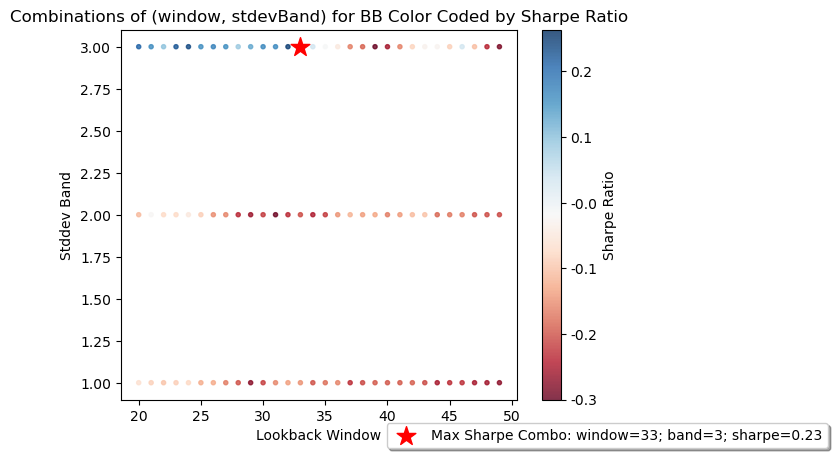

Instrument Name: GBP


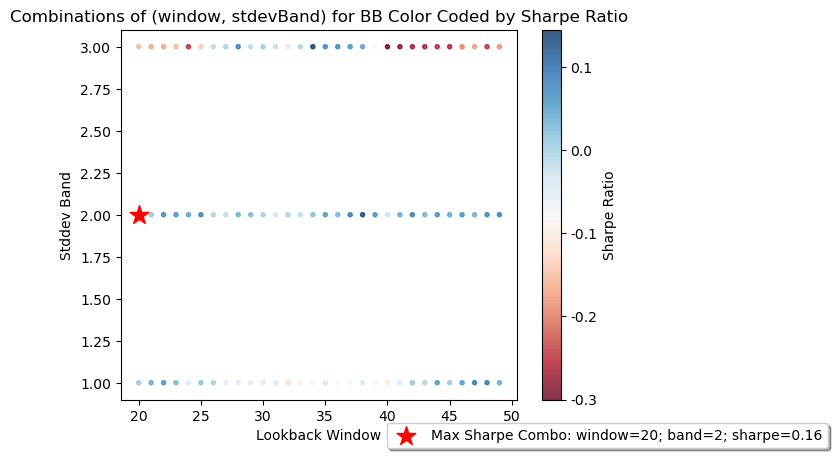

Instrument Name: GE


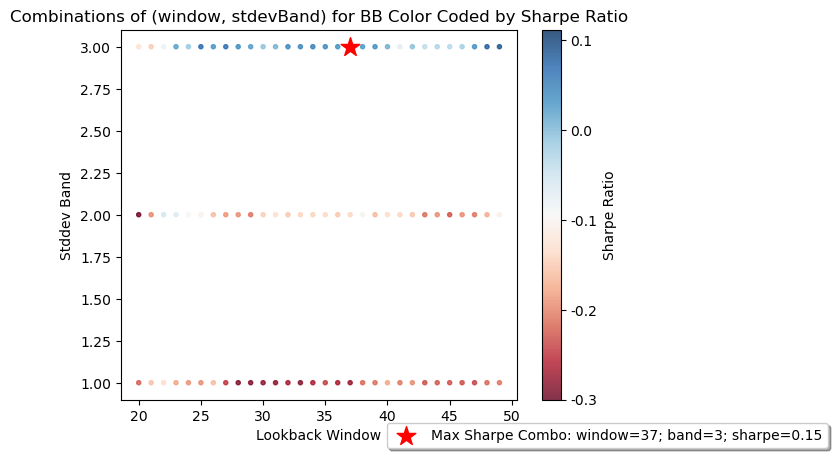

Instrument Name: INTC


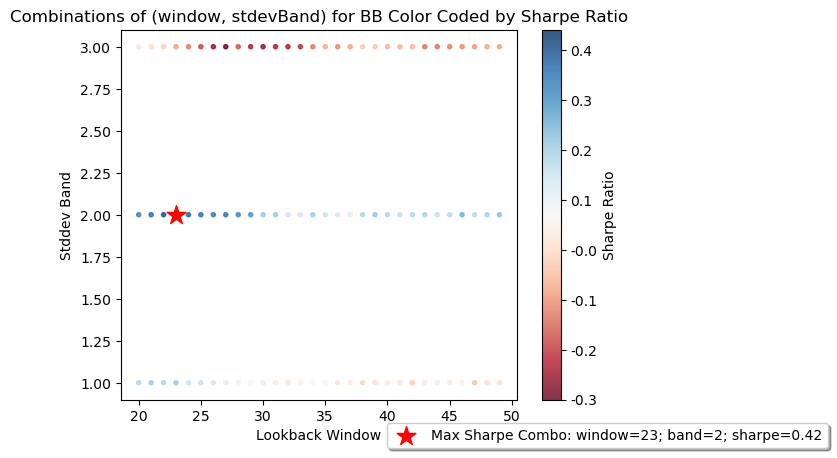

Instrument Name: PFE


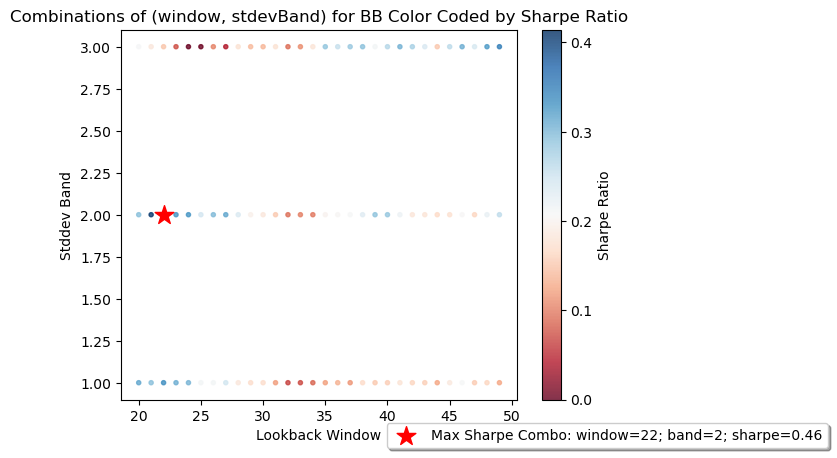

Instrument Name: SPGSCI


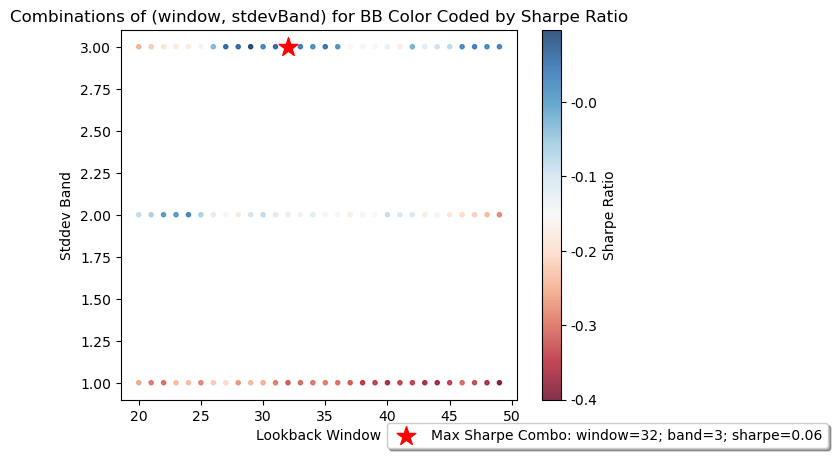

Instrument Name: SPY


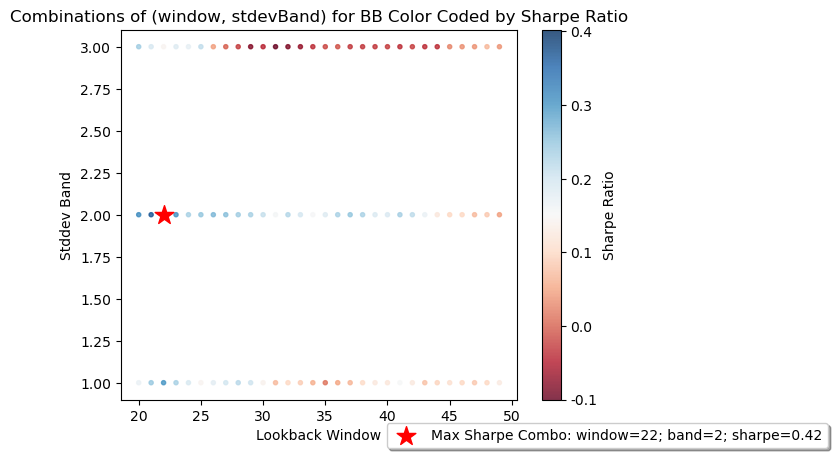

Instrument Name: VBTIX


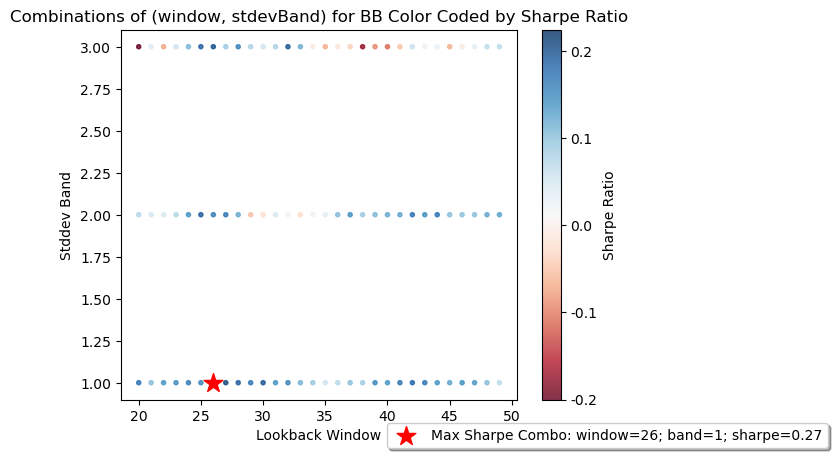

Instrument Name: XPT


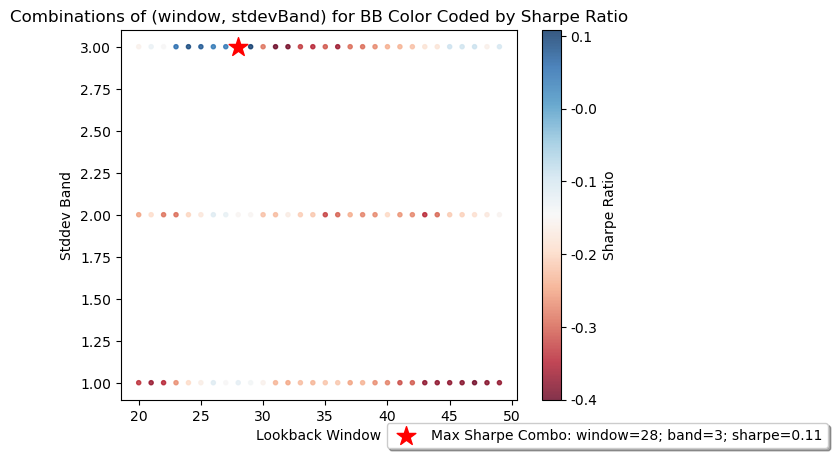

In [14]:
for column in prices_df.columns:
    print(f'Instrument Name: {column}')
    dataframe = pd.DataFrame(prices_df[column])

    bb_sharpes = []

    for lookback_window in range(20, 50):
        for stdev_band in np.arange(1, 4):

            # Apply the Bollinger Bands strategy to the DataFrame
            result_df = bollingerBands(dataframe, lookback_window, stdev_band)

            bollinger_returns = result_df.iloc[:, 1]
            mean = bollinger_returns.mean()
            std = bollinger_returns.std()

            # Check if the strategy traded (non-zero daily returns)
            if ((mean==0.0)&(std==0.0)):
                bb_sharpes.append(np.nan)
                #print(f'BB strategy: no trade since strategy daily returns zero for lookback_window:{lookback_window}, stdev_band:{stdev_band}')
            else:
                # Calculate Sharpe ratio for the Bollinger Band strategy
                bb_sharpes.append(mean / std * np.sqrt(annualization_factor))
                #print(lookback_window,stdev_band,mean / std * np.sqrt(annualization_factor))

    # Convert bb_sharpes list to a NumPy array
    bb_sharpes_array = np.array(bb_sharpes)

    lookback_window = range(20, 50)
    stdev_band = range(1, 4)

    # Find the maximum Sharpe value and its index
    max_sharpe_value = max(bb_sharpes)
    max_sharpe_index = bb_sharpes.index(max_sharpe_value)

    # Calculate corresponding parameters
    num_stdev_bands = len(stdev_band)
    optimal_lookback_window = lookback_window[max_sharpe_index // num_stdev_bands]
    optimal_stdev_band = stdev_band[max_sharpe_index % num_stdev_bands]

    # Generate all combinations of window and stddev
    all_combos = list(product(lookback_window, stdev_band))

    # Create the scatter plot with Sharpe ratios as the color
    scatter = plt.scatter(*zip(*all_combos), c=bb_sharpes_array.flatten(), cmap='RdBu', marker='.', alpha=0.8)

    # Highlight the point with the maximum Sharpe ratio in red
    plt.scatter(optimal_lookback_window, optimal_stdev_band, c='red', marker='*', s=200, label=f'Max Sharpe Combo: window={optimal_lookback_window}; band={optimal_stdev_band}; sharpe={max_sharpe_value:.2f}')

    # Determine the range for colorbar ticks
    min_tick = np.nanmin(bb_sharpes_array)
    max_tick = np.nanmax(bb_sharpes_array)

    # Set colorbar ticks with equal spacing of 0.1
    ticks = np.arange(min_tick, max_tick, 0.1)

    # Add colorbar with red-to-blue colormap and white at 0
    cbar = plt.colorbar(scatter, label='Sharpe Ratio', ticks=ticks)
    cbar.set_ticklabels([f'{tick:.1f}' for tick in ticks])

    # Add legend at the bottom
    plt.legend(loc='lower right', bbox_to_anchor=(1.8, -0.15), fancybox=True, shadow=True, ncol=1)

    plt.xlabel("Lookback Window")
    plt.ylabel("Stddev Band")
    plt.title('Combinations of (window, stdevBand) for BB Color Coded by Sharpe Ratio')

    # Show the plot
    plt.show()


### Choices Selected:

- Any 5 equity instruments: AAPL-MAFLAT, GE-MAShort, INTC-BB, PFE-BB, SPY-MAFlat
- 1 of the 2 fixed income instruments: FBN-MAShort 
- 1 of the 2 commodity instruments: XPT-MAShort
- 1 of the 2 currency pairs: GBP-MAShort


# 3.

Rationale for choices:

For Moving Averages(MA) strategy, range of parameters for analysis:
- fastWindow = range(5, 110)
- slowWindow = range(50, 500, 5)

For Bollinger Bands strategy, range of parameters for analysis:

- lookback_window in range(20, 50)
- stdev_band in np.arange(1, 4)

##### Considering these parameters and strategies, maximum sharpes obtained for each instrument in the dataset is given below:

<table>
  <tr>
    <th style="text-align: center;"><u>Sharpe<u/></th>
    <th>AAPL</th>
    <th>EXC</th>
    <th>GE</th>
    <th>INTC</th>
    <th>PFE</th>
    <th>SPY</th>
    <th>FBNDX</th>
    <th>VBTIX</th>
    <th>SPGSCI</th>
    <th>XPT</th>
    <th>CAD</th>
    <th>GBP</th>
  </tr>
  <tr>
    <td style="text-align: center;"><b>Returns</b></td>
    <td>0.47</td>
    <td>0.20</td>
    <td>-0.33</td>
    <td>0.02</td>
    <td>0.06</td>
    <td>0.15</td>
    <td>0.15</td>
    <td>0.13</td>
    <td>0.15</td>
    <td>0.14</td>
    <td>0.03</td>
    <td>-0.13</td>      
  </tr>
  <tr>
    <td style="text-align: center;"><b>MAFlat</b></td>
    <td style="color: red;"><u><b>1.01</b></u></td>
    <td>0.41</td>
    <td>0.25</td>
    <td>0.21</td>
    <td>0.21</td>
    <td style="color: red;"><u><b>0.65</b></u></td>
    <td>0.59</td>
    <td>0.30</td>
    <td>0.51</td>
    <td>0.52</td>
    <td>0.41</td>
    <td>0.38</td>      
  </tr>
  <tr>
    <td style="text-align: center;"><b>MAShort</b></td>
    <td>0.82</td>
    <td>0.42</td>
      <td style="color: red;"><u><b>0.59</b></u></td>
    <td>0.26</td>
    <td>0.26</td>
    <td>0.57</td>
    <td style="color: red;"><u><b>0.69</b></u></td>
    <td style="color: red;">0.31</td>
    <td style="color: red;">0.61</td>
    <td style="color: red;"><u><b>0.64</b></u></td>
    <td style="color: red;">0.51</td>
    <td style="color: red;"><u><b>0.56</b></u></td>     
  </tr>
  <tr>
    <td><b>Bollinger Bands</b></td>
    <td>0.08</td>
    <td style="color: red;">0.50</td>
    <td>0.15</td>
    <td style="color: red;"><u><b>0.42</b></u></td>
    <td style="color: red;"><u><b>0.46</b></u></td>
    <td>0.42</td>
    <td>0.23</td>
    <td>0.27</td>
    <td>0.16</td>
    <td>0.11</td>
    <td>0.36</td>
    <td>0.16</td>      
  </tr>    
  <!-- Add remaining rows in a similar format -->
</table>


Values highlighted in red are the maximum sharpe's obtained among all strategies for that particular instrument (maximum value along each column is highlighted).

After manually inspecting overlapping blue regions in the plots, values highlighted and underlined in red are the ones chosen for the portfolio:
- MAFlat overlapping regions for AAPL, SPY: fastWindow(10-25), slowWindow(220-240)
- MAShort overlapping regions for FBNDX, XPT, GBP: fastWindow(80-100), slowWindow(100-120)
- Bollinger Bands (BB) for INTC,PFE: lookback_window(22-23), stdev_band(2) 


# 4.

In [15]:
# Equities:

# Define the parameters
fastWindow = 11
slowWindow = 220
lookback_window = 22
stdev_band = 2

# Apply MA crossover and Bollinger Band strategies
apple_df = movingAverageCrossover(pd.DataFrame(prices_df['AAPL']), fastWindow, slowWindow)
apple_df_stats = calcSummaryStatistics(apple_df, print_screen=True)

ge_df = movingAverageCrossover(pd.DataFrame(prices_df['GE']), fastWindow, slowWindow)
ge_df_stats = calcSummaryStatistics(ge_df, print_screen=True)

spy_df = movingAverageCrossover(pd.DataFrame(prices_df['SPY']), fastWindow, slowWindow)
spy_df_stats = calcSummaryStatistics(spy_df, print_screen=True)

intc_bb_df = bollingerBands(pd.DataFrame(prices_df['INTC']), lookback_window, stdev_band)
intc_bb_df_stats = calcSummaryStatistics(intc_bb_df, print_screen=True)

pfe_bb_df = bollingerBands(pd.DataFrame(prices_df['PFE']), lookback_window, stdev_band)
pfe_bb_df_stats = calcSummaryStatistics(pfe_bb_df, print_screen=True)


                       AAPL-BMK AAPL-MAFlat AAPL-MAShort
Average Annual Return    27.10%      27.81%       28.53%
Annual Risk              37.54%      27.47%       37.53%
maxDD                   -93.82%     -55.13%      -76.07%
Success Ratio            52.35%      65.92%       53.25%
Sharpe Ratio           0.721821    1.012515     0.759997
                        EXC-BMK EXC-MAFlat EXC-MAShort
Average Annual Return     2.35%      1.70%       1.05%
Annual Risk              25.57%     17.15%      25.57%
maxDD                  -128.08%    -67.90%     -94.62%
Success Ratio            52.24%     71.03%      51.95%
Sharpe Ratio           0.092064   0.099262    0.041094
                         GE-BMK GE-MAFlat GE-MAShort
Average Annual Return   -11.19%     0.47%     12.14%
Annual Risk              31.02%    14.22%     31.02%
maxDD                  -211.69%   -31.17%    -90.44%
Success Ratio            49.98%    74.67%     51.80%
Sharpe Ratio          -0.360685  0.033361   0.391275
          

In [16]:
# Other assets

# Define the parameters
fastWindow = 93
slowWindow = 104

# Apply MA crossover strategy
fbndx_df = movingAverageCrossover(pd.DataFrame(prices_df['FBNDX']), fastWindow, slowWindow)
fbndx_df_stats = calcSummaryStatistics(fbndx_df, print_screen=True)

xpt_df = movingAverageCrossover(pd.DataFrame(prices_df['XPT']), fastWindow, slowWindow)
xpt_df_stats = calcSummaryStatistics(xpt_df, print_screen=True)

gbp_df = movingAverageCrossover(pd.DataFrame(prices_df['GBP']), fastWindow, slowWindow)
gbp_df_stats = calcSummaryStatistics(gbp_df, print_screen=True)

                      FBNDX-BMK FBNDX-MAFlat FBNDX-MAShort
Average Annual Return     0.68%        1.08%         1.49%
Annual Risk               3.79%        2.71%         3.79%
maxDD                   -23.70%       -9.89%       -12.36%
Success Ratio            64.88%       81.01%        63.92%
Sharpe Ratio           0.178976     0.398499      0.392473
                        XPT-BMK XPT-MAFlat XPT-MAShort
Average Annual Return     2.00%      8.22%      14.44%
Annual Risk              22.25%     15.60%      22.23%
maxDD                  -107.43%    -58.97%     -66.89%
Success Ratio            52.74%     73.18%      52.67%
Sharpe Ratio           0.090031   0.527139    0.649666
                        GBP-BMK GBP-MAFlat GBP-MAShort
Average Annual Return    -0.89%      1.79%       4.46%
Annual Risk               9.53%      5.82%       9.52%
maxDD                   -55.30%    -14.69%     -31.53%
Success Ratio            50.79%     75.45%      51.35%
Sharpe Ratio          -0.093331   0.30660

Creating a new dataFrame which has the daily returns of the 8 chosen strategies with below format:
- columns named appropriately.
- columns ordered as follows: first, the chosen 5 equities in alphabetical order, then fixed income, then commodity, and finally currency.

In [17]:
# Perform the inner join of the necessary columns
portfolio_returns_df = pd.DataFrame(apple_df['AAPL-MAFlat']).join([
    ge_df['GE-MAShort'],
    intc_bb_df['INTC-BB'],
    pfe_bb_df['PFE-BB'],
    spy_df['SPY-MAFlat'],
    fbndx_df['FBNDX-MAShort'],
    xpt_df['XPT-MAShort'],
    gbp_df['GBP-MAShort']
], how='inner')

# Note that the first row has Nan values, dropping the row to calculate stats and compare
portfolio_returns_df = portfolio_returns_df.dropna() 

# Calculate performance statistics for the combined DataFrame
portfolio_returns_df_stats = calcSummaryStatistics(portfolio_returns_df, print_screen=False)
portfolio_returns_df_stats

AAPL-MAFlat GE-MAShort   INTC-BB    PFE-BB SPY-MAFlat  \
Average Annual Return      27.81%     12.14%    10.82%     9.06%      5.46%   
Annual Risk                27.47%     31.02%    25.95%    18.56%     10.58%   
maxDD                     -55.13%    -90.44%   -45.33%   -30.51%    -19.50%   
Success Ratio              65.92%     51.80%    74.71%    74.19%     69.56%   
Sharpe Ratio             1.012515   0.391275  0.416923  0.487879   0.515852   

                      FBNDX-MAShort XPT-MAShort GBP-MAShort  
Average Annual Return         1.47%      14.30%       4.30%  
Annual Risk                   3.80%      22.16%       9.52%  
maxDD                       -12.36%     -66.89%     -31.53%  
Success Ratio                63.84%      52.63%      51.32%  
Sharpe Ratio               0.387584    0.645098    0.451441

##### List out the column names:

In [18]:
myPortfolioColumns = list(portfolio_returns_df.columns)
myPortfolioColumns

['AAPL-MAFlat',
 'GE-MAShort',
 'INTC-BB',
 'PFE-BB',
 'SPY-MAFlat',
 'FBNDX-MAShort',
 'XPT-MAShort',
 'GBP-MAShort']

# 5.

### Correlation structure of the portfolio:

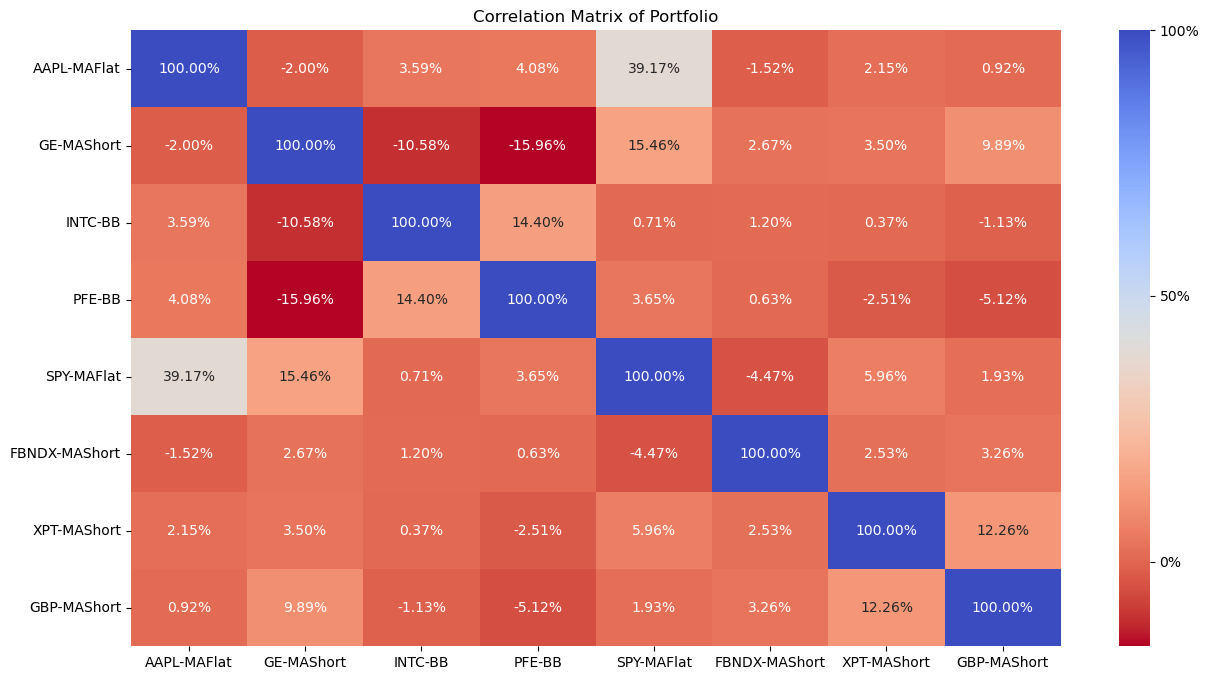

In [53]:
# Calculate the correlation matrix
correlation_matrix = portfolio_returns_df.corr()

plt.figure(figsize=(15,8))
plt.title('Correlation Matrix of Portfolio') 
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt='.2%', cmap='coolwarm_r')

# Modify the color bar to display percentages
colorbar = heatmap.collections[0].colorbar
colorbar.set_ticks([0, 0.5, 1])  # Adjust these ticks according to your data
colorbar.set_ticklabels(['0%', '50%', '100%'])  # Format these labels as needed
plt.savefig('Correlation_Mx.png')

plt.show()



The correlation matrix unveils the relationships among various instruments. Key observations reveal a notably strong positive correlation between 'AAPL-MAFlat' and 'SPY-MAFlat' (39.17%), indicating a robust connection between Apple and the S&P 500. Conversely, 'GE-MAShort' shows weaker associations, notably -15.96% with 'PFE-BB'. 'INTC-BB' exhibits moderate positive correlations, the highest being 14.40% with 'PFE-BB'. Overall, while some pairs show moderate to strong relationships, others demonstrate weaker or negligible correlations, emphasizing the diverse interplay between the assets.

# 6.

### Equal-Weight portfolio

#### **Single line calculation**:

In [20]:
# Creating an equal weight vector
equal_weights = np.array([1 / portfolio_returns_df.shape[1]] * portfolio_returns_df.shape[1])


# Using the Matrix formulation for portfolio return and risk for determining annualized sharpe
equal_weight_portfolio_sharpe = ( (annualization_factor * np.dot(equal_weights, portfolio_returns_df.mean().T))/ (np.sqrt(annualization_factor) * np.sqrt(np.dot(np.dot(equal_weights, portfolio_returns_df.cov()), equal_weights.T))) )

print(f'Annualized Sharpe of an equal-weighted portfolio: {equal_weight_portfolio_sharpe}')

Annualized Sharpe of an equal-weighted portfolio: 1.380192564662937


Yes, the equal-weight portfolio with Sharpe of 1.38 outperform every individual strategy. An equal-weighted portfolio spreads investments evenly across multiple assets, mitigating the risk of poor performance in any single asset and stabilizing overall returns. By diversifying, the portfolio can reduce the impact of specific risk factors inherent in individual assets, thereby lowering overall risk. Additionally, the assets in the portfolio may not move in perfect correlation; their returns might offset each other's fluctuations, ensuring a more consistent return stream.

##### The higher Sharpe ratio of the equal-weighted portfolio reflects its superior risk-adjusted returns, highlighting the effectiveness of diversification in balancing risk and optimizing returns across a diversified set of assets.


# 7.

### Mean-Variance Optimization (MVO):

Using a 5,000-step Monte Carlo simulation with a seed of 64:

In [21]:
# Set a random seed
rng = np.random.default_rng(seed=64)

# Define the number of paths for the Monte Carlo simulation
num_paths = 5000

prets = [] # we'll collect the returns in this list
pvols = [] # and the risks in this one
weight_vectors = []

for i in range(num_paths):
    # Generate random weights
    wts = rng.random(portfolio_returns_df.shape[1])
    wts /= np.sum(wts)  # Normalize the weights to add up to 100%
    
    # Copy the weights into the array
    weight_vectors.append(wts)

    # Calculate the portfolio return and risk for the current path's set of weights
    prets.append(annualization_factor * np.dot(wts, portfolio_returns_df.mean().T)) # return for this combo
    pvols.append(np.sqrt(annualization_factor) * np.sqrt(np.dot(np.dot(wts, portfolio_returns_df.cov()), wts.T))) # risk for this combo
    
# Convert both the lists to numpy arrays
prets = np.array(prets)
pvols = np.array(pvols)


We have assembled all the different weight vectors in '**weight_vectors**' variable to identify the weights of the minimum-vol and the maximum-sharpe portfolios.

# 8,9,10.

### Scatter Plot

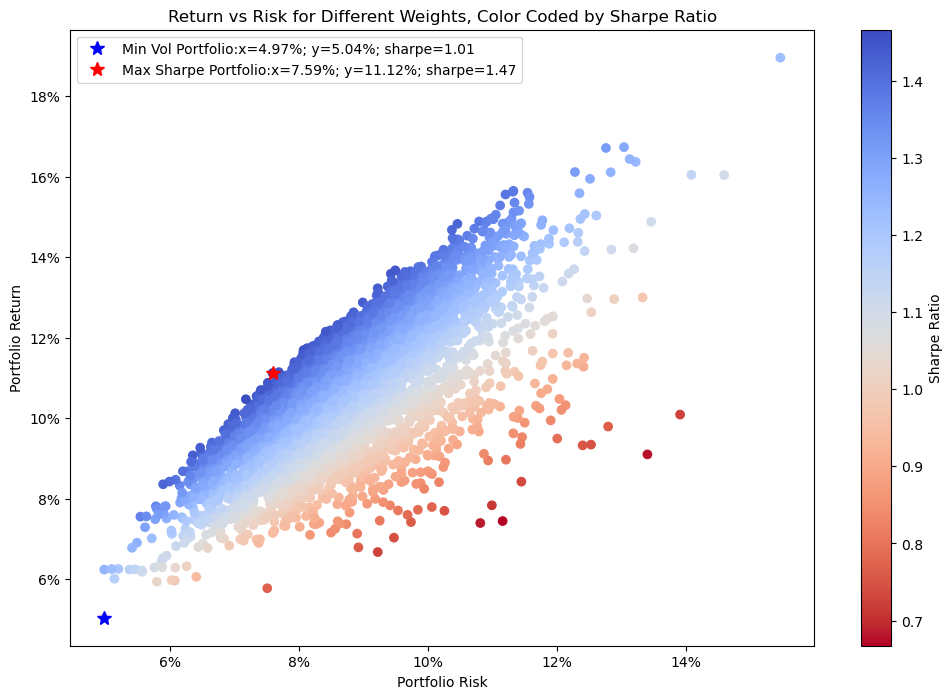

In [22]:
# Plotting all 5000 portfolios

plt.figure(figsize=aspect_ratio)
ax = plt.subplot()
plt.scatter(pvols, prets, c = prets/pvols, marker='o', cmap='coolwarm_r')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.title('Return vs Risk for Different Weights, Color Coded by Sharpe Ratio')
plt.xlabel('Portfolio Risk')
plt.ylabel('Portfolio Return')
plt.colorbar(label='Sharpe Ratio')
plt.plot(pvols[np.argmin(pvols)], prets[np.argmin(pvols)], 'b*', markersize=10.0, label='Min Vol Portfolio:x={:.2%}; y={:.2%}; sharpe={:1.2f}'.format(pvols[np.argmin(pvols)], prets[np.argmin(pvols)], prets[np.argmin(pvols)]/pvols[np.argmin(pvols)])) 
plt.plot(pvols[np.argmax(prets/pvols)], prets[np.argmax(prets/pvols)], 'r*', markersize=10.0, label='Max Sharpe Portfolio:x={:.2%}; y={:.2%}; sharpe={:1.2f}'.format(pvols[np.argmax(prets/pvols)], prets[np.argmax(prets/pvols)], np.max(prets/pvols)))
plt.legend()

plt.show()

### Weights of Minimum Volatility portfolio

In [23]:
min_vol_weights = weight_vectors[np.argmin(pvols)]
min_vol_weights

array([0.00216467, 0.0196062 , 0.02138644, 0.02016675, 0.27560033,
       0.28493821, 0.07896443, 0.29717298])

Rationalization of Minimum Volatility Weight Vector:

- **AAPL-MAFlat:** The weight allocated is rather minimal at 0.21%. This allocation stems from its high risk relative to return. Although showing a moderate Sharpe ratio and a decent success rate, its contribution is limited due to the higher risk it poses to the portfolio.

- **GE-MAShort:** The weight allocated is 1.96%, relatively low because of its high volatility, substantial drawdown, and lower success and Sharpe ratios. Its contribution is restrained to manage the overall risk of the portfolio.

- **INTC-BB:** The weight allocated stands at 2.14%, reflecting its lower risk and moderate success metrics. Its contribution is moderated to balance the risk exposure.

- **PFE-BB:** With a weight of 2.02%, its slightly higher weight is due to its relatively lower risk and moderate success metrics, making a balanced contribution to the portfolio's risk profile.

- **SPY-MAFlat:** Having a weight of 27.56%, despite its lower return, its significantly lower risk attributes to the higher weight. Its lower risk considerably enhances the portfolio's overall stability.

- **FBNDX-MAShort:** A significant weight of 28.49% is assigned to this asset, driven by its minimal risk and satisfactory risk-adjusted returns. It plays a substantial role in reducing the portfolio's overall volatility.

- **XPT-MAShort:** Despite its higher risk, the weight allocated is 7.90%, supported by its higher returns and favorable risk-return metrics, making a moderate contribution to the portfolio.

- **GBP-MAShort:** With a weight of 29.72%, its higher allocation is due to its lower risk and moderate returns, playing a significant role in managing the portfolio's overall risk profile.


The weight distribution in the portfolio aims to minimize overall volatility by strategically assigning weights to individual assets based on their risk-return profiles and contributions to the portfolio's stability. The weight allocated for AAPL-MAFlat is minimal due to its high risk relative to return. Although it has a decent success rate and a moderate Sharpe ratio, its high risk contributes less to the portfolio's overall stability. Assets with higher returns but substantial risk, like GE-MAShort and XPT-MAShort, have smaller weights to reduce the overall portfolio risk. The allocation reflects a meticulous balance: assets like FBNDX-MAShort and GBP-MAShort, with minimal risk and satisfactory returns, carry significant weights to reduce overall portfolio volatility. Conversely, assets like GE-MAShort, despite lower returns and higher risk, hold minimal weights to limit their impact on the portfolio's stability. This careful distribution allows for a diverse mix of assets—some contribute moderately to returns, while others, despite lower returns, significantly reduce the portfolio's overall risk. The approach emphasizes the importance of managing risk while aiming for reasonable returns across the diverse set of assets within the portfolio.


### Weights of Maximum Sharpe portfolio

In [24]:
max_sharpe_weights = weight_vectors[np.argmax(prets/pvols)]
max_sharpe_weights

array([0.17143388, 0.0762359 , 0.06332   , 0.17258526, 0.03777947,
       0.16811505, 0.13946747, 0.17106296])

Rationalization of Maximum Sharpe Weight Vector:

- **AAPL-MAFlat:** This asset has a weight of 17.14%. It demonstrates the highest average annual return of 27.81%, substantiating its higher allocation in the portfolio to maximize returns. However, it also has relatively higher risk (27.47%) compared to some other assets.

- **GE-MAShort:** The weight allocated to this asset is 7.62%. It exhibits a lower average annual return of 12.14% and significantly higher risk (31.02%). The lower weight assigned might be due to its higher risk without a proportionate increase in return.

- **INTC-BB:** With a weight of 6.32%, it has an average annual return of 10.82% and an annual risk of 25.95%. Its weight is relatively lower due to the higher risk compared to some assets with similar or higher returns.

- **PFE-BB:** The weight allocated to this asset is 17.25%. It has an average annual return of 9.06% and an annual risk of 18.56%. Its lower weight might result from a slightly lower return compared to other assets with similar or lower risk.

- **SPY-MAFlat:** This asset is allocated 3.78% weight, despite offering a lower average annual return of 5.46% and moderate risk of 10.58%. Its lower return might have resulted in a slightly lower allocation.

- **FBNDX-MAShort:** This asset has a weight of 16.81%. Although it offers a modest average annual return of 1.47%, it has the lowest annual risk of 3.80%. Its higher weight might be due to its lower risk, contributing to portfolio diversification and reducing overall volatility.

- **XPT-MAShort:** With a weight of 13.94%, this asset provides an average annual return of 14.30% and an annual risk of 22.16%. Its higher return potential with moderate risk contributes to its allocation.

- **GBP-MAShort:** The weight allocated is 17.11%, and the asset demonstrates an average annual return of 4.30% and an annual risk of 9.52%. Its higher weight might be attributed to its moderate risk and the need to balance the portfolio's overall risk profile.

The weight allocation seems to reflect a trade-off between returns and risk, favoring assets with better risk-adjusted returns and lower volatility to optimize the portfolio's Sharpe ratio. Assets with higher returns or lower risk received higher weights, while those with lower returns or higher risk received relatively lower weights in an attempt to achieve a more balanced risk-return profile.

# 11.

YES, maximum Sharpe is 1.47 which is greater than equal weight Sharpe of 1.38.

1. Equal Weight Portfolio Sharpe Ratio: The annualized Sharpe of an equal-weighted portfolio is 1.38. This strategy assigns an equal weight to each asset in the portfolio.

2. Maximum Sharpe Portfolio:
- The portfolio with the maximum Sharpe ratio has optimized weights for each asset. The higher Sharpe ratio (1.47) of the optimized portfolio indicates that this portfolio has better risk-adjusted returns compared to the equal-weighted portfolio (Sharpe ratio of 1.38). It suggests that by optimizing the allocation of weights, we were able to achieve a higher return for the same level of risk (or lower risk for the same level of return) compared to the equally-weighted strategy.

- By assigning different weights to assets based on their risk and return characteristics, the optimized portfolio achieves a more efficient diversification.

# 12.

In [25]:
max_sharpe_portfolio = pd.DataFrame((max_sharpe_weights * portfolio_returns_df).sum(axis=1, skipna=False), columns=['Max Sharpe Portfolio'])
max_sharpe_portfolio = portfolio_returns_df.join(max_sharpe_portfolio, how='inner')
max_sharpe_stats = calcSummaryStatistics(max_sharpe_portfolio, print_screen=False)
max_sharpe_stats

AAPL-MAFlat GE-MAShort   INTC-BB    PFE-BB SPY-MAFlat  \
Average Annual Return      27.81%     12.14%    10.82%     9.06%      5.46%   
Annual Risk                27.47%     31.02%    25.95%    18.56%     10.58%   
maxDD                     -55.13%    -90.44%   -45.33%   -30.51%    -19.50%   
Success Ratio              65.92%     51.80%    74.71%    74.19%     69.56%   
Sharpe Ratio             1.012515   0.391275  0.416923  0.487879   0.515852   

                      FBNDX-MAShort XPT-MAShort GBP-MAShort  \
Average Annual Return         1.47%      14.30%       4.30%   
Annual Risk                   3.80%      22.16%       9.52%   
maxDD                       -12.36%     -66.89%     -31.53%   
Success Ratio                63.84%      52.63%      51.32%   
Sharpe Ratio               0.387584    0.645098    0.451441   

                      Max Sharpe Portfolio  
Average Annual Return               11.12%  
Annual Risk                          7.59%  
maxDD                               -8.80%  
Success Ratio                       53.97%  
Sharpe Ratio                      1.466141

- The Max Sharpe Portfolio has a lower average annual return compared to some individual components like AAPL-MAFlat, but it achieves this with significantly lower annual risk, resulting in a higher Sharpe Ratio. The Max Sharpe Portfolio has a more favorable risk-return tradeoff, as reflected in its lower annual risk and drawdown.

Let's adjust risk for Max Sharpe portfolio by considering AAPL-MAFlat, as it has higher average annual returns compared to other instruments:


<table>
  <tr>
    <th> </th>
    <th>AAPL-MAFlat</th>
    <th>Max Sharpe Portfolio</th>
  </tr>
  <tr>
      <td> <b>Average Annual Return </b></td>
    <td>27.81%</td>
    <td>11.12%</td>
  </tr>
  <tr>
      <td> <b>Annual Risk </b></td>
    <td>27.47%</td>
    <td>7.59%</td>
  </tr>    
  <!-- Add more rows as needed -->
</table>


Risk and return will be adjusted with a factor of 27.47/7.59 = 3.6192 for Max Sharpe Portfolio:

<table>
  <tr>
    <th> </th>
    <th>AAPL-MAFlat</th>
    <th>Max Sharpe Portfolio</th>
  </tr>
  <tr>
      <td> <b>Average Annual Return </b></td>
    <td>27.81%</td>
    <td>40.25%</td>
  </tr>
  <tr>
      <td> <b>Annual Risk </b></td>
    <td>27.47%</td>
    <td>27.47%</td>
  </tr>    
  <!-- Add more rows as needed -->
</table>


Equalizing risk results in higher average annual returns (40.25%) for Max Sharpe Portfolio compared to AAPL-MAFlat (27.81%).

- The Max Sharpe Portfolio has a Success Ratio of 53.97%, indicating that it has positive returns on about 53.97% of the observed days. Some individual components like INTC-BB and PFE-BB have higher Success Ratios, suggesting a higher frequency of positive returns on observed days.

# 13. 

In [26]:
# Calculating Beta
combined_data = pd.concat([max_sharpe_portfolio['Max Sharpe Portfolio'], logReturns['SPY']], axis=1).dropna()

# Setting up X variable
X = combined_data['SPY']

# Set up the constant vector so that we get a non-zero alpha
X = sm.add_constant(X)

# Setting up Y variable
y = combined_data['Max Sharpe Portfolio']

# Linear regression
portfolio_Reg = sm.OLS(y, X)

# Fit the data in the OLS regression object that has been instantiated
portfolio_Reg = portfolio_Reg.fit()

beta = portfolio_Reg.params.SPY

# Beta term
print(f"The beta-term of maximum Sharpe ratio portfolio to S&P500 is: : {beta:.4f}")

The beta-term of maximum Sharpe ratio portfolio to S&P500 is: : 0.0917


A beta value of 0.0917 indicates a relatively low sensitivity of the maximum Sharpe ratio portfolio to movements in the S&P 500 index. In the context of the Capital Asset Pricing Model (CAPM), beta measures the portfolio's systematic risk concerning the market. A beta below 1 indicates that the portfolio is less sensitive to market movements than the benchmark index. If the market (S&P 500) goes up or down by 1%, the portfolio, based on this beta, is expected to move approximately 0.0917%, indicating less volatility than the market.

For investors, a beta less than 1 might be interpreted as a measure of lower risk because the portfolio doesn't fluctuate as much as the overall market. It can be seen as a form of diversification that offers some protection during market downturns. However, there are potential disadvantages to having a beta less than 1. While it may provide downside protection during bearish market periods, it might not capture all the gains during bullish phases, potentially limiting upside potential. 

# 14. 

#### a.

In [40]:
# Perform the inner join of the necessary columns
portfolio_returns_BMK = pd.DataFrame(logReturns['AAPL']).join([
    logReturns['GE'],
    logReturns['INTC'],
    logReturns['PFE'],
    logReturns['SPY'],
    logReturns['FBNDX'],
    logReturns['XPT'],
    logReturns['GBP']
], how='inner')

# Drop NaN values
portfolio_returns_BMK = portfolio_returns_BMK.dropna()

portfolio_returns_BMK = portfolio_returns_BMK.loc[portfolio_returns_BMK.index > '2000-11-12']

# Creating an equal weight vector
equal_weights_BMK = np.array([1 / portfolio_returns_BMK.shape[1]] * portfolio_returns_BMK.shape[1])

# Single line calculation:
# Using the Matrix formulation for portfolio return and risk for determining annualized sharpe
equal_weight_portfolio_sharpe_BMK = ( (annualization_factor * np.dot(equal_weights_BMK, portfolio_returns_BMK.mean().T))/ (np.sqrt(annualization_factor) * np.sqrt(np.dot(np.dot(equal_weights_BMK, portfolio_returns_BMK.cov()), equal_weights_BMK.T))) )

print(f"Sharpe of an equal-weighted portfolio (BMK): {equal_weight_portfolio_sharpe_BMK:.4f}")


Sharpe of an equal-weighted portfolio (BMK): 0.1864


#### b.

In [41]:
# Apply MAFlat strategy to each instrument
portfolio_returns_MAFlat = pd.DataFrame()
for column in ['AAPL', 'GE', 'INTC', 'PFE', 'SPY', 'FBNDX', 'XPT', 'GBP']:
    df = pd.DataFrame(prices_df[column])
    ma_flat_df = movingAverageCrossover(df, 11, 220)
    portfolio_returns_MAFlat = portfolio_returns_MAFlat.join(ma_flat_df[column + '-MAFlat'], how='outer')

# Drop NaN values
portfolio_returns_MAFlat = portfolio_returns_MAFlat.dropna()

portfolio_returns_MAFlat = portfolio_returns_MAFlat.loc[portfolio_returns_MAFlat.index > '2000-11-12']


# Calculate Sharpe Ratio
equal_weights_MAFlat = np.array([1 / portfolio_returns_MAFlat.shape[1]] * portfolio_returns_MAFlat.shape[1])
equal_weight_portfolio_sharpe_MAFlat = ( (annualization_factor * np.dot(equal_weights_MAFlat, portfolio_returns_MAFlat.mean().T))/ (np.sqrt(annualization_factor) * np.sqrt(np.dot(np.dot(equal_weights_MAFlat, portfolio_returns_MAFlat.cov()), equal_weights_MAFlat.T))) )

print(f'Annualized Sharpe of an equal-weighted MAFlat portfolio: {equal_weight_portfolio_sharpe_MAFlat}')


Annualized Sharpe of an equal-weighted MAFlat portfolio: 0.6216634928793838


#### c.

In [42]:
# Apply MAShort strategy to each instrument
portfolio_returns_MAShort = pd.DataFrame()
for column in ['AAPL', 'GE', 'INTC', 'PFE', 'SPY', 'FBNDX', 'XPT', 'GBP']:
    df = pd.DataFrame(prices_df[column])
    ma_short_df = movingAverageCrossover(df, 93, 104)
    portfolio_returns_MAShort = portfolio_returns_MAShort.join(ma_short_df[column + '-MAShort'], how='outer')

# Drop NaN values
portfolio_returns_MAShort = portfolio_returns_MAShort.dropna()

portfolio_returns_MAShort = portfolio_returns_MAShort.loc[portfolio_returns_MAShort.index > '2000-11-12']


# Calculate Sharpe Ratio
equal_weights_MAShort = np.array([1 / portfolio_returns_MAShort.shape[1]] * portfolio_returns_MAShort.shape[1])
equal_weight_portfolio_sharpe_MAShort = ( (annualization_factor * np.dot(equal_weights_MAShort, portfolio_returns_MAShort.mean().T))/ (np.sqrt(annualization_factor) * np.sqrt(np.dot(np.dot(equal_weights_MAShort, portfolio_returns_MAShort.cov()), equal_weights_MAShort.T))) )

print(f'Annualized Sharpe of an equal-weighted MAShort portfolio: {equal_weight_portfolio_sharpe_MAShort}')


Annualized Sharpe of an equal-weighted MAShort portfolio: 0.43689788259012025


#### d.

In [43]:
# Apply BB strategy to each instrument
portfolio_returns_BB = pd.DataFrame()
for column in ['AAPL', 'GE', 'INTC', 'PFE', 'SPY', 'FBNDX', 'XPT', 'GBP']:
    df = pd.DataFrame(prices_df[column])
    bb_df = bollingerBands(df, lookback_window, stdev_band)
    portfolio_returns_BB = portfolio_returns_BB.join(bb_df[column + '-BB'], how='outer')

# Drop NaN values
portfolio_returns_BB = portfolio_returns_BB.dropna()
portfolio_returns_BB = portfolio_returns_BB.loc[portfolio_returns_BB.index > '2000-11-12']

# Calculate Sharpe Ratio
equal_weights_BB = np.array([1 / portfolio_returns_BB.shape[1]] * portfolio_returns_BB.shape[1])
equal_weight_portfolio_sharpe_BB = ( (annualization_factor * np.dot(equal_weights_BB, portfolio_returns_BB.mean().T))/ (np.sqrt(annualization_factor) * np.sqrt(np.dot(np.dot(equal_weights_BB, portfolio_returns_BB.cov()), equal_weights_BB.T))) )

print(f'Annualized Sharpe of an equal-weighted BB portfolio: {equal_weight_portfolio_sharpe_BB}')


Annualized Sharpe of an equal-weighted BB portfolio: 0.06294020908166312


##### None of these 4 portfolios outperform the chosen Max Sharpe Portfolio of 1.47 from #10

"We pledge on our honor that we have not given nor received any unauthorized assistance on this
assignment to/from other groups. Nor have we received any assistance from prior year students."
- Lakshita Garg, Satvik Narang, Thanmai Reddy, Pruthvi Billa, Kristina Sutliff